[SCEC BP3-QD](https://strike.scec.org/cvws/seas/download/SEAS_BP3.pdf) document is here.

In [1]:
from tectosaur2.nb_config import setup

setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term
from tectosaur2.elastic2d import elastic_t, elastic_h
from tectosaur2.mesh import panelize_symbolic_surface
from tectosaur2.debug import plot_centers

In [34]:
surf_half_L = 1000000
fault_length = 40000
max_panel_length = 400
n_fault = 400
mu = shear_modulus = 3.2e10
nu = 0.25

qx, qw = gauss_rule(6)
sp_t = sp.var("t")

edges = np.linspace(-1, 1, n_fault+1)
panel_bounds = np.stack((edges[:-1],edges[1:]), axis=1)
angle_rad = sp.pi / 6
sp_x = (sp_t + 1) / 2 * sp.cos(angle_rad) * fault_length
sp_y = -(sp_t + 1) / 2 * sp.sin(angle_rad) * fault_length
fault = panelize_symbolic_surface(
    sp_t, sp_x, sp_y,
    panel_bounds,
    qx, qw
)

free = refine_surfaces(
    [
        (sp_t, -sp_t * surf_half_L, 0 * sp_t)  # free surface
    ],
    (qx, qw),
    control_points = [
        # nearfield surface panels and fault panels will be limited to 200m
        # at 200m per panel, we have ~40m per solution node because the panels
        # have 5 nodes each
        (0, 0, 1.5 * fault_length, max_panel_length),
        (0, 0, 0.2 * fault_length, 1.5 * fault_length / (n_fault)),
        # farfield panels will be limited to 200000 m per panel at most
        (0, 0, surf_half_L, 50000),
    ]
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 646 panels with a total of 3876 points.
The fault mesh has 400 panels with a total of 2400 points.


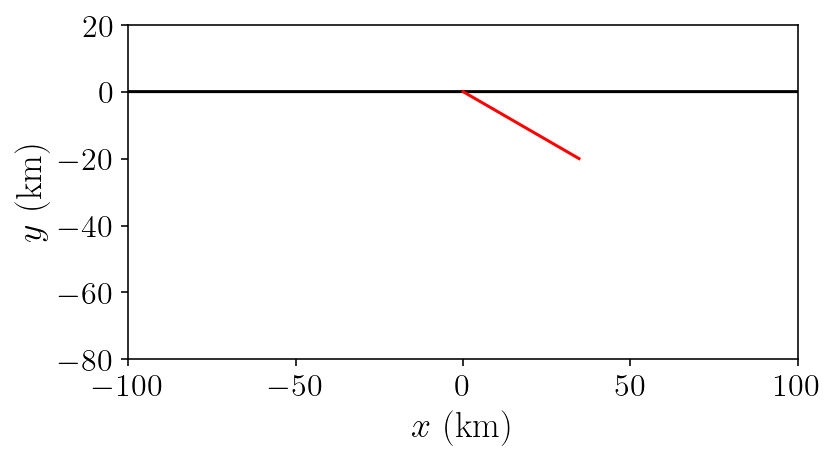

In [35]:
plt.plot(free.pts[:,0]/1000, free.pts[:,1]/1000, 'k-')
plt.plot(fault.pts[:,0]/1000, fault.pts[:,1]/1000, 'r-')
plt.xlabel(r'$x ~ \mathrm{(km)}$')
plt.ylabel(r'$y ~ \mathrm{(km)}$')
plt.axis('scaled')
plt.xlim([-100, 100])
plt.ylim([-80, 20])
plt.show()

And, to start off the integration, we'll construct the operators necessary for solving for free surface displacement from fault slip.

In [36]:
singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [0, 0],
        [float(sp_x.subs(sp_t,1)), float(sp_y.subs(sp_t,1))],
    ]
)

In [37]:
(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    elastic_t(nu), free.pts, free, fault, singularities=singularities, safety_mode=True, return_report=True
)

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


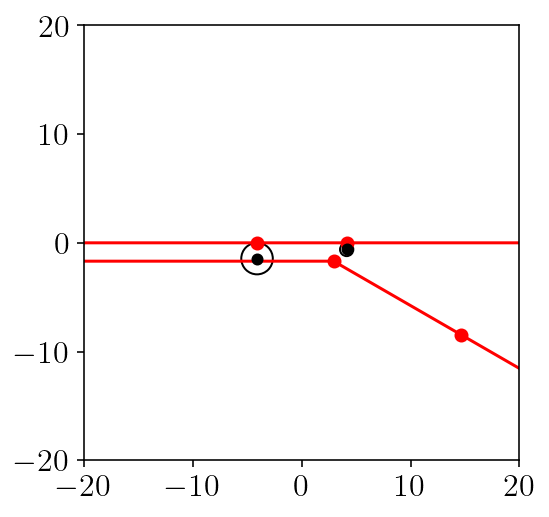

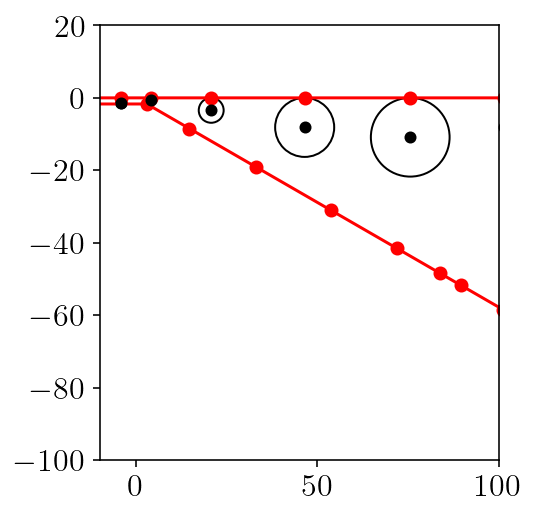

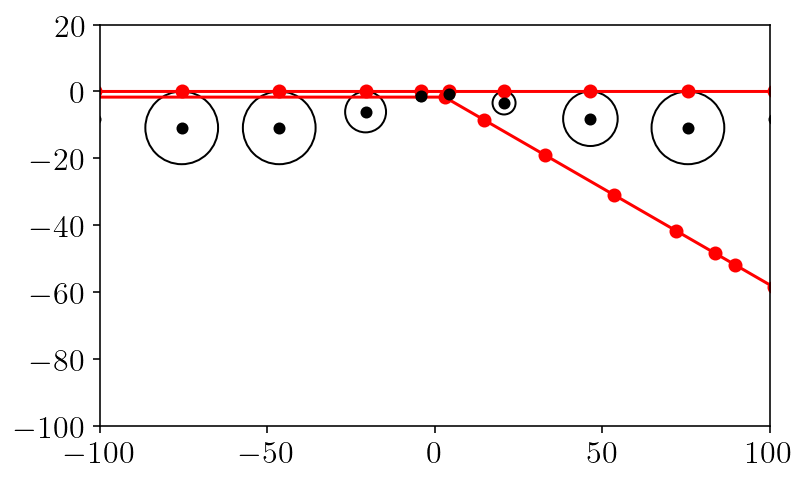

In [38]:
plot_centers(report, [-20, 20], [-20, 20])
plt.show()
plot_centers(report, [-10, 100], [-100, 20])
plt.show()
plot_centers(report, [-100, 100], [-100, 20])
plt.show()

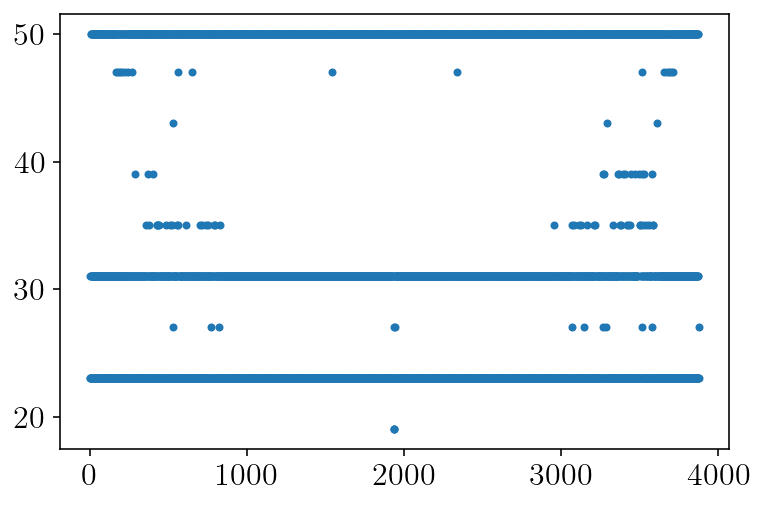

In [39]:
plt.plot(report['p'], '.')
plt.show()

In [40]:

fault_slip_to_free_disp = fault_slip_to_free_disp.reshape((-1, 2 * fault.n_pts))
free_disp_to_free_disp = free_disp_to_free_disp.reshape((-1, 2 * free.n_pts))
free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
)

In [41]:
from tectosaur2.elastic2d import ElasticH
(free_disp_to_fault_stress, fault_slip_to_fault_stress), report = integrate_term(
    # Integration is much easier if the output are order 1, so we
    # pass a shear_modulus of 1.0 and then multiply by shear_modulus later
    ElasticH(nu, d_cutoff=8.0),
    # elastic_h(nu),
    fault.pts,
    free,
    fault,
    tol=1e-12,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= shear_modulus
free_disp_to_fault_stress *= shear_modulus

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:174: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(
/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:180: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


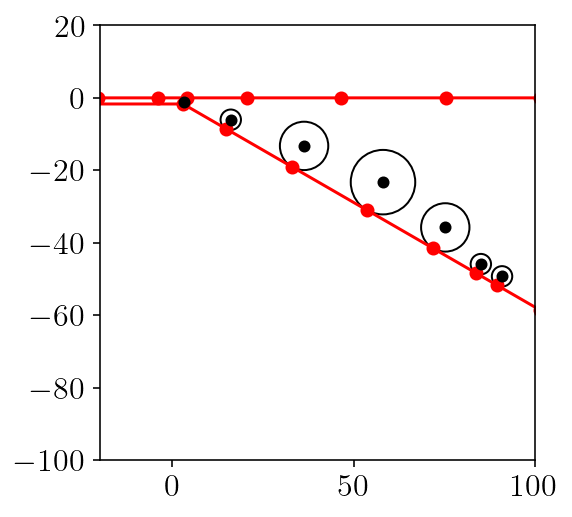

In [42]:
plot_centers(report, [-20, 100], [-100, 20])

[ 162  168  180  186  192  198  204  210  216  222  228  234  240  246
  252  258  264  270  275  276  281  282  287  288  293  294  299  300
  305  306  311  312  317  318  323  324  329  330  335  336  341  342
  347  348  353  354  359  360  365  366  371  372  377  378  383  384
  389  390  395  396  401  402  407  408  413  414  419  420  425  426
  431  432  437  438  443  444  449  450  455  456  461  462  467  468
  473  474  479  480  485  486  491  492  497  498  503  504  509  510
  515  516  521  522  527  528  533  534  539  540  545  546  551  552
  557  558  563  564  569  570  575  576  581  582  587  588  593  594
  599  600  605  606  611  612  617  618  623  624  629  630  635  636
  641  642  647  648  653  654  659  660  665  666  671  672  677  678
  683  684  689  690  695  696  701  702  707  708  713  714  719  720
  725  726  731  732  737  738  743  744  749  750  755  756  761  762
  767  768  773  774  779  780  785  786  791  792  797  798  803  804
  809 

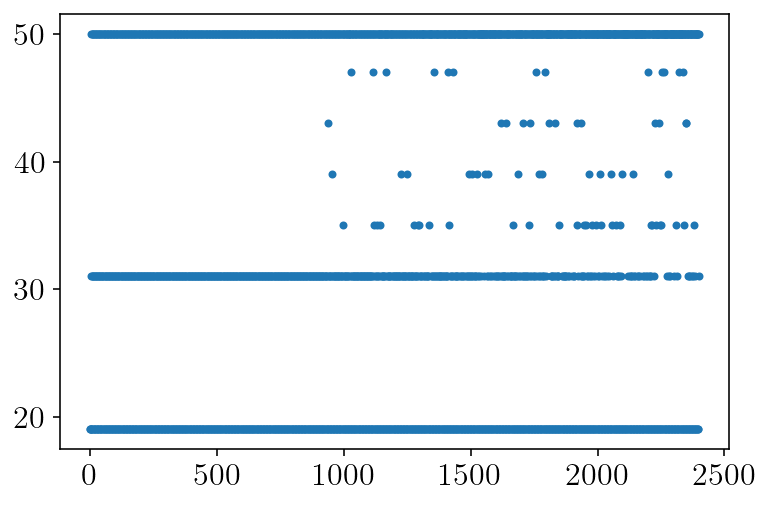

In [43]:
print(np.where(report['integration_failed'])[0])
plt.plot(report['p'], '.')
plt.show()

In [44]:

A = fault_slip_to_fault_stress.reshape((-1, 2*fault.n_pts))
B = free_disp_to_fault_stress.reshape((-1, 2*free.n_pts))
C = fault_slip_to_free_disp
Dinv = np.linalg.inv(free_disp_solve_mat)
total_fault_slip_to_fault_stress = A - B.dot(Dinv.dot(C))

nx = fault.normals[:, 0]
ny = fault.normals[:, 1]
normal_mult = np.transpose(np.array([
    [nx, ny, 0*nx], [0*nx, nx, ny]
]), (2,0,1))

total_fault_slip_to_fault_traction = np.sum(
    total_fault_slip_to_fault_stress.reshape((-1,3,fault.n_pts,2))[:,None,:,:,:] * normal_mult[:, :, :, None, None], axis=2
).reshape((-1, 2 * fault.n_pts))

In [45]:
def exact_displacements(x):
    s = -1
    delta = np.arctan2(-float(sp_y.subs(sp_t,1)), float(sp_x.subs(sp_t,1)))
    d = -float(sp_y.subs(sp_t, 1))
    xd = float(sp_x.subs(sp_t, 1))#d / np.tan(delta)
    print(delta, d, xd)
    xsi = (x - xd) / d
    exact_ux = (-s / np.pi) * (
            np.cos(delta) * (np.arctan(xsi) - (np.pi / 2) * np.sign(x)) +
            (np.sin(delta) - xsi * np.cos(delta)) / (1 + xsi ** 2))
    exact_uy = (s / np.pi) * (
            np.sin(delta) * (np.arctan(xsi) - (np.pi / 2) * np.sign(x)) +
            (np.cos(delta) + xsi * np.sin(delta)) / (1 + xsi ** 2))
    return exact_ux, exact_uy
    
# def dislocation_stress(mu, nu, pts, x_dsl, d, s1, s2):
#     x = pts[:,0] - x_dsl
#     y = pts[:,1]
#     r1 = np.sqrt(x ** 2 + (y - d) **2)
#     r2 = np.sqrt(x ** 2 + (y + d) ** 2)
#     sxx = mu * s2 / (2 * np.pi * (1-nu)) * (
#         x * ((y - d)**2 - x**2) / (r1 ** 4)
#         - x * ((y + d) ** 2 - x**2) / (r2 ** 4)
#         + (4 * d * y / (r2 ** 6)) * ((2 * d - y) * (y + d) ** 2 + (3 * y + 2 * d) * x**2)
#     ) - 2 * mu * s1 / (
#         (y - d)* ((y-d)**2 + 3 * x**2) / (r1**4) 
#         - (y + d) * ((y + d) ** 2 + 3 * x**2) / (r2**4)
#         + 2 * y / (r2 ** 6) * (6*y*(y+d)*x**2 - (y - d) *(y+d)**3 - x**4)
#     )
#     return sxx

# def exact_stress(pts):
#     return dislocation_stress(1.0, nu, pts, 0, 0, np.sin(float(angle_rad)), np.cos(float(angle_rad)))

0.5235987755982989 20000.0 34641.016151377546


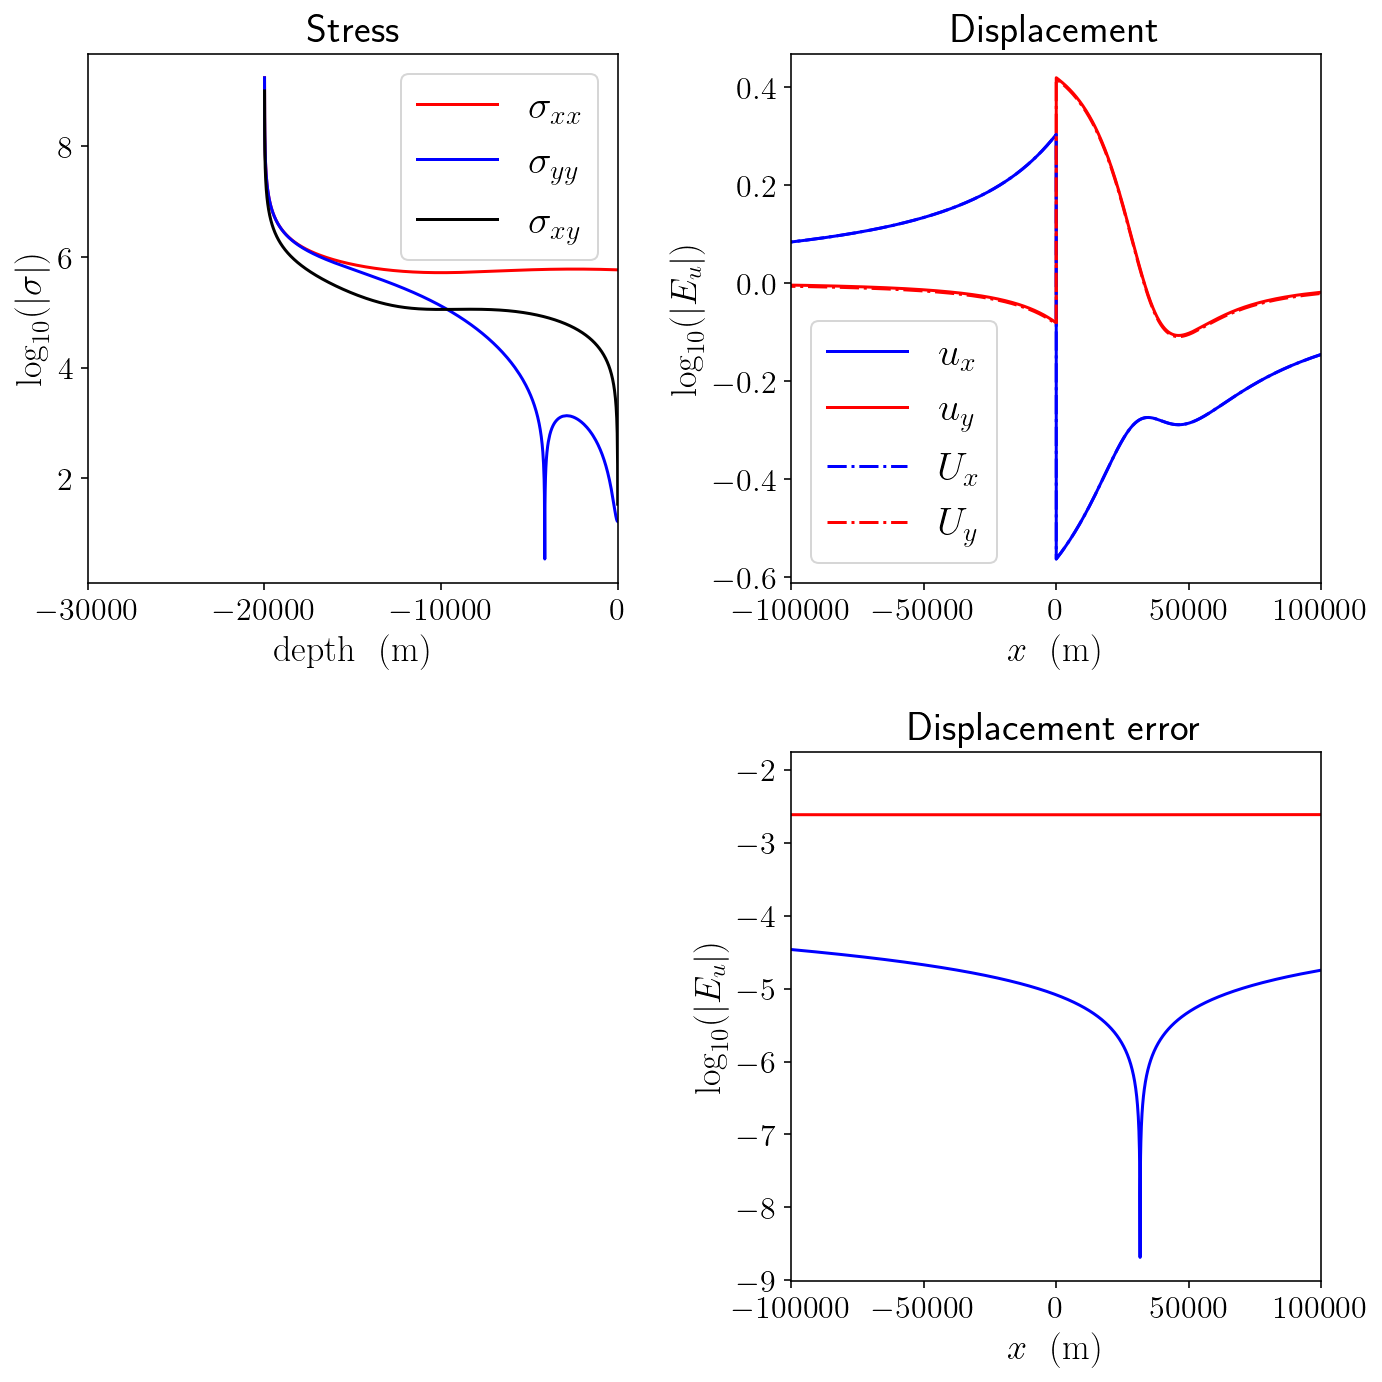

In [46]:
slip = np.stack((-ny, nx), axis=1)
slip_op = -Dinv.dot(C)
numerical_sd = slip_op.dot(slip.ravel())
analytical_ux, analytical_uy = exact_displacements(free.pts[:,0])
numerical_fs = total_fault_slip_to_fault_stress.dot(slip.ravel())

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Stress')
plt.plot(fault.pts[:,1], np.log10(np.abs(numerical_fs[::3])), 'r-', label=r'$\sigma_{xx}$')
plt.plot(fault.pts[:,1], np.log10(np.abs(numerical_fs[1::3])), 'b-', label=r'$\sigma_{yy}$')
plt.plot(fault.pts[:,1], np.log10(np.abs(numerical_fs[2::3])), 'k-', label=r'$\sigma_{xy}$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-30000, 0])
plt.xlabel('$\mathrm{depth ~~ (m)}$')
plt.ylabel('$\log_{10}(|\sigma|)$')
plt.subplot(2,2,2)
plt.title('Displacement')
plt.plot(free.pts[:,0], numerical_sd[0::2], 'b-', label='$u_x$')
plt.plot(free.pts[:,0], numerical_sd[1::2], 'r-', label='$u_y$')
plt.plot(free.pts[:,0], analytical_ux, 'b-.', label='$U_x$')
plt.plot(free.pts[:,0], analytical_uy, 'r-.', label='$U_y$')
plt.legend()
plt.xlim([-100000, 100000])
plt.xlabel('$x ~~ \mathrm{(m)}$')
plt.ylabel('$\log_{10}(|E_u|)$')
plt.subplot(2,2,4)
plt.title('Displacement error')
plt.plot(free.pts[:,0], np.log10(np.abs(analytical_ux - numerical_sd[::2])), 'b-')
plt.plot(free.pts[:,0], np.log10(np.abs(analytical_uy - numerical_sd[1::2])), 'r-')
plt.xlim([-100000, 100000])
plt.xlabel('$x ~~ \mathrm{(m)}$')
plt.ylabel('$\log_{10}(|E_u|)$')
plt.tight_layout()
plt.show()

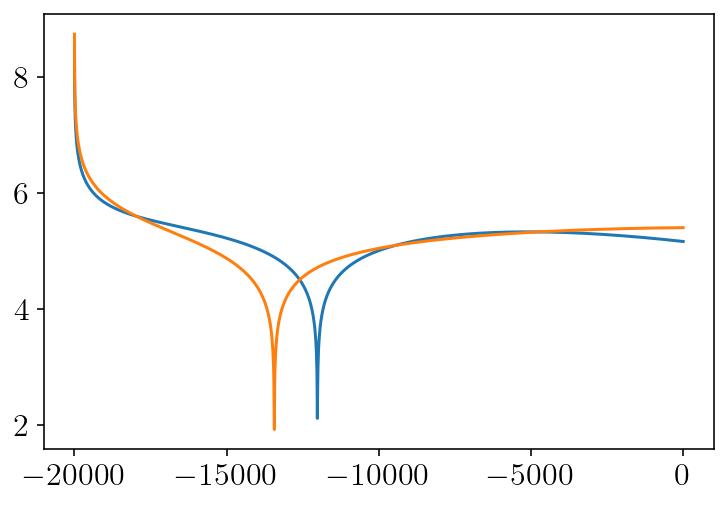

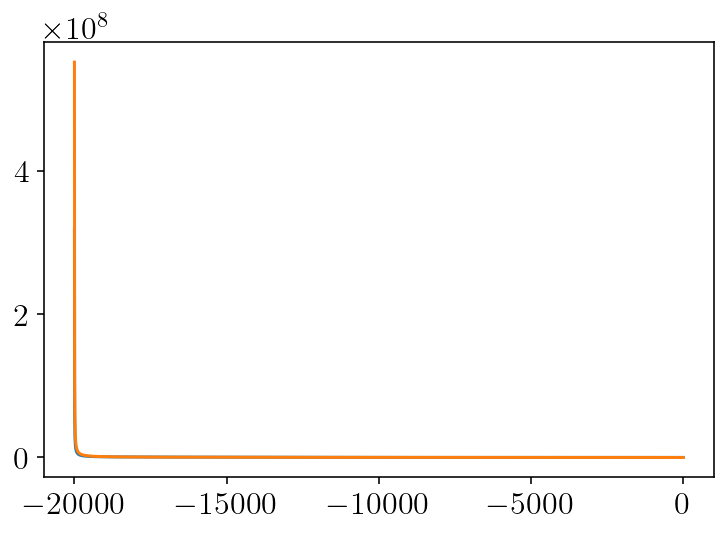

In [47]:
numerical_ft = np.sum(numerical_fs.reshape((-1,1,3))*normal_mult,axis=2)
normal_trac = np.sum(numerical_ft * np.stack((nx, ny), axis=1), axis=1)
get_normal_trac = lambda t: np.sum(t * np.stack((nx, ny), axis=1), axis=1)
get_shear_trac = lambda t: np.sum(t * np.stack((ny, -nx), axis=1), axis=1)
plt.plot(fault.pts[:,1], np.log10(np.abs(get_normal_trac(numerical_ft))))
plt.plot(fault.pts[:,1], np.log10(np.abs(get_shear_trac(numerical_ft))))
plt.show()
plt.plot(fault.pts[:,1], get_normal_trac(numerical_ft))
plt.plot(fault.pts[:,1], get_shear_trac(numerical_ft))
plt.show()

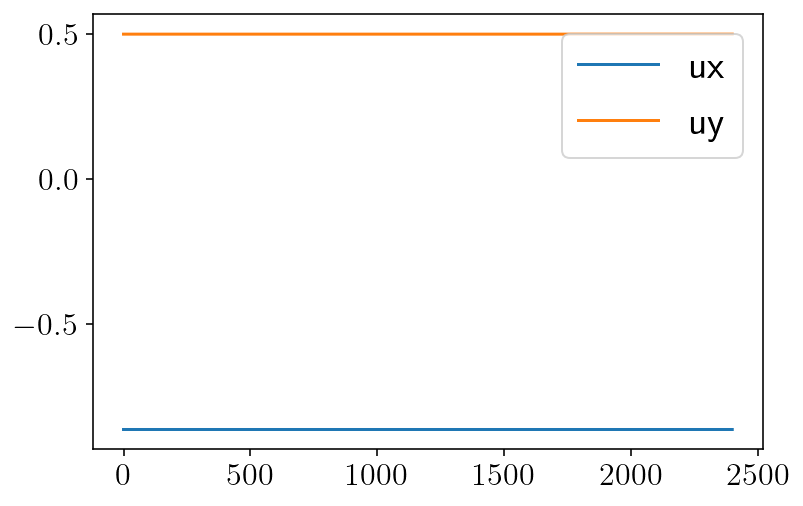

In [48]:
plt.plot(slip[:,0], label='ux')
plt.plot(slip[:,1], label='uy')
plt.legend()
plt.show()

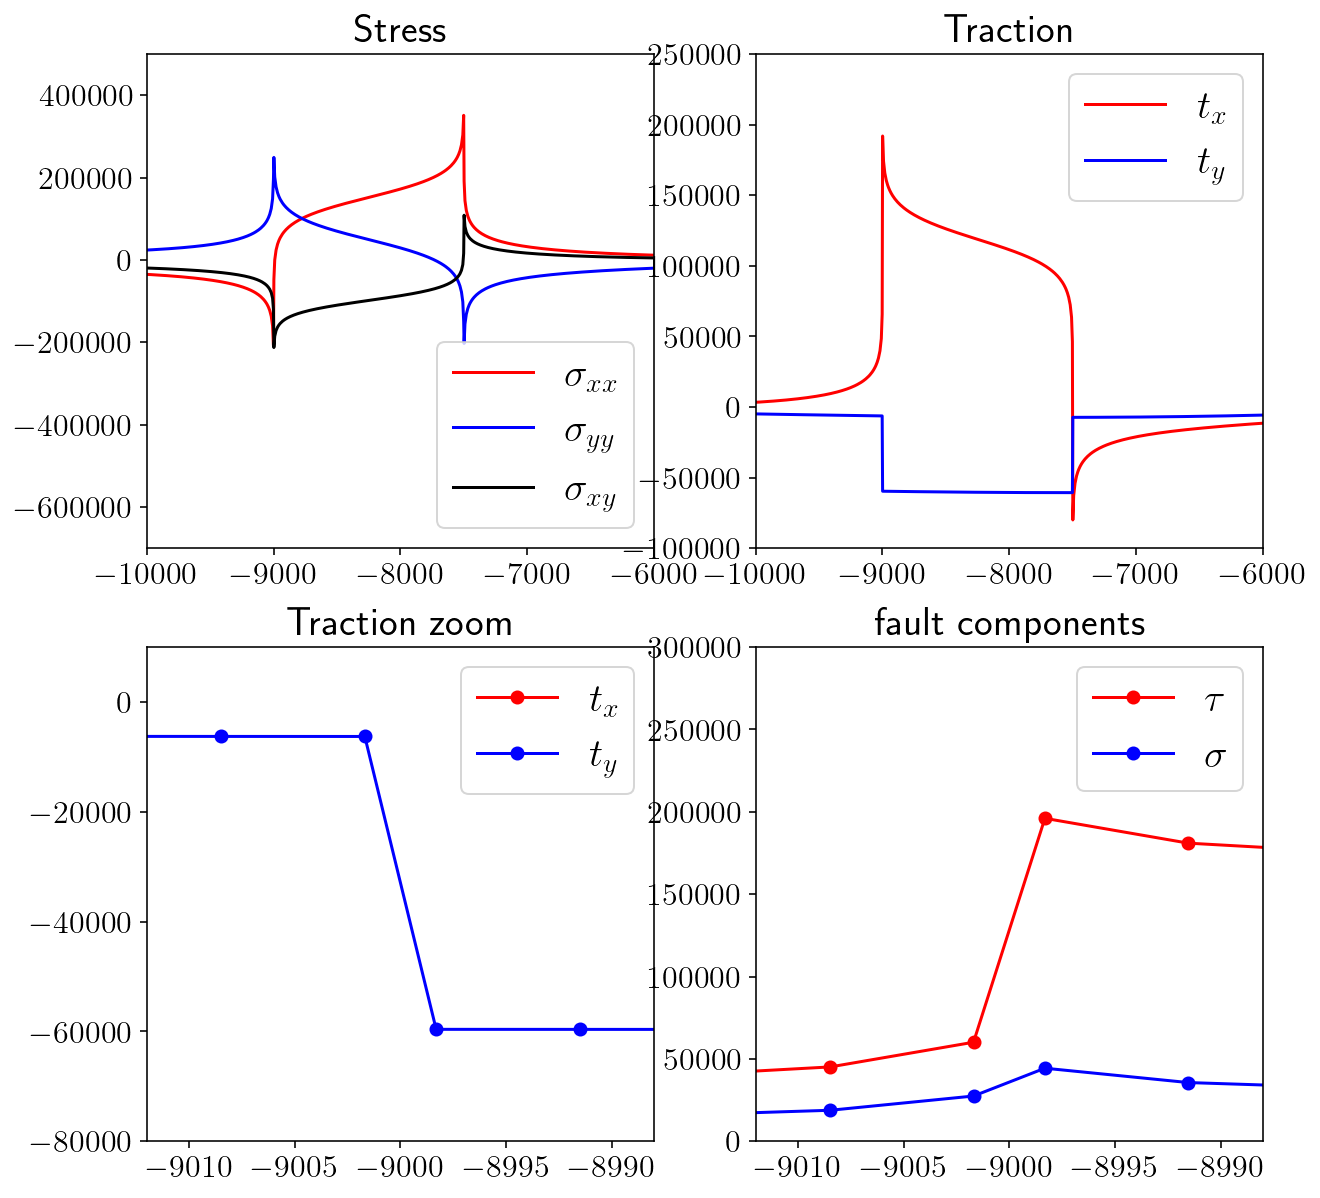

In [49]:
a0 = 0.01
amax = 0.025
H = 15000
h = 3000
fx = fault.pts[:, 0]
fy = fault.pts[:, 1]
fd = -np.sqrt(fx ** 2 + fy ** 2)
# fpd = -np.sqrt(fault.panel_centers[:,0] ** 2 + fault.panel_centers[:,1] ** 2j)
fp_a = np.where(
    fd > -H, a0, np.where(fd > -(H + h), a0 + (amax - a0) * (fd + H) / -h, amax)
)
numerical_kink = total_fault_slip_to_fault_stress.dot((slip * fp_a[:,None]).ravel())
numerical_kink_t = np.sum(numerical_kink.reshape((-1,1,3))*normal_mult,axis=2)
numerical_kink_st = get_shear_trac(numerical_kink_t)
numerical_kink_nt = get_normal_trac(numerical_kink_t)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title('Stress')
plt.plot(fault.pts[:,1], numerical_kink[::3], 'r-', label=r'$\sigma_{xx}$')
plt.plot(fault.pts[:,1], numerical_kink[1::3], 'b-', label=r'$\sigma_{yy}$')
plt.plot(fault.pts[:,1], numerical_kink[2::3], 'k-', label=r'$\sigma_{xy}$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-10000, -6000])
plt.ylim([-0.7e6,0.5e6])
plt.subplot(2,2,2)
plt.title('Traction')
plt.plot(fault.pts[:,1], numerical_kink_t[:,0], 'r-', label=r'$t_{x}$')
plt.plot(fault.pts[:,1], numerical_kink_t[:,1], 'b-', label=r'$t_{y}$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-10000, -6000])
plt.ylim([-0.1e6,0.25e6])
plt.subplot(2,2,3)
plt.title('Traction zoom')
plt.plot(fault.pts[:,1], numerical_kink_t[:,0], 'r-o', label=r'$t_{x}$')
plt.plot(fault.pts[:,1], numerical_kink_t[:,1], 'b-o', label=r'$t_{y}$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-9012, -8988])
plt.ylim([-0.08e6,0.01e6])
plt.subplot(2,2,4)
plt.title('fault components')
plt.plot(fault.pts[:,1], numerical_kink_st, 'r-o', label=r'$\tau$')
plt.plot(fault.pts[:,1], numerical_kink_nt, 'b-o', label=r'$\sigma$')
plt.legend()
plt.xlim([np.min(fault.pts[:,1]), 0])
plt.xlim([-9012, -8988])
plt.ylim([-0e5, 3e5])
plt.show()

## Rate and state friction

Okay, now that we've constructed the necessary boundary integral operators, we get to move on to describing the frictional behavior on the fault.

#### TODO: Explain!!

In [50]:
siay = 31556952  # seconds in a year
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
eta = shear_modulus / (2 * cs)  # The radiation damping coefficient (kg / (m^2 * s))
Vp = 1e-9  # Rate of plate motion
sigma_n0 = 50e6  # Normal stress (Pa)

# parameters describing "a", the coefficient of the direct velocity strengthening effect
a0 = 0.01
amax = 0.025
H = 15000
h = 3000
fx = fault.pts[:, 0]
fy = fault.pts[:, 1]
fd = -np.sqrt(fx ** 2 + fy ** 2)
# fpd = -np.sqrt(fault.panel_centers[:,0] ** 2 + fault.panel_centers[:,1] ** 2j)
fp_a = np.where(
    fd > -H, a0, np.where(fd > -(H + h), a0 + (amax - a0) * (fd + H) / -h, amax)
)

# state-based velocity weakening effect
fp_b = 0.015

# state evolution length scale (m)
fp_Dc = 0.008

# baseline coefficient of friction
fp_f0 = 0.6

# if V = V0 and at steady state, then f = f0, units are m/s
fp_V0 = 1e-6


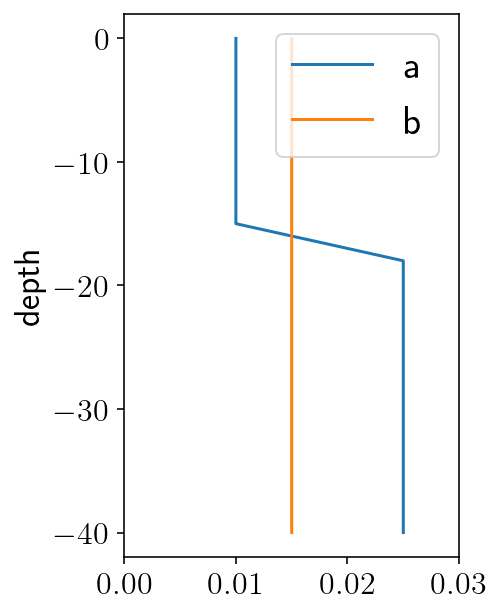

In [51]:
plt.figure(figsize=(3, 5))
plt.plot(fp_a, fd/1000, label='a')
plt.plot(np.full(fy.shape[0], fp_b), fd/1000, label='b')
plt.xlim([0, 0.03])
plt.ylabel('depth')
plt.legend()
plt.show()

In [52]:
# The regularized form of the aging law. 
def aging_law(fp_a, V, state):
    return (fp_b * fp_V0 / fp_Dc) * (np.exp((fp_f0 - state) / fp_b) - (V / fp_V0))

def qd_equation(fp_a, normal_stress, shear_stress, V, state):
    # The regularized rate and state friction equation
    F = normal_stress * fp_a * np.arcsinh(V / (2 * fp_V0) * np.exp(state / fp_a))
    
    # The full shear stress balance:
    return shear_stress - eta * V - F

def qd_equation_dV(fp_a, normal_stress, V, state):
    # First calculate the derivative of the friction law with respect to velocity
    # This is helpful for equation solving using Newton's method
    expsa = np.exp(state / fp_a)
    Q = (V * expsa) / (2 * fp_V0)
    dFdV = fp_a * expsa * normal_stress / (2 * fp_V0 * np.sqrt(1 + Q * Q))

    # The derivative of the full shear stress balance.
    return -eta - dFdV


def solve_friction(fp_a, normal_stress, shear_stress, V_old, state, tol=1e-14):
    V = V_old
    max_iter = 150
    for i in range(max_iter):
        # Newton's method step!
        f = qd_equation(fp_a, normal_stress, shear_stress, V, state)
        dfdv = qd_equation_dV(fp_a, normal_stress, V, state)
        step = f / dfdv

        # We know that slip velocity should not be negative so any step that
        # would lead to negative slip velocities is "bad". In those cases, we
        # cut the step size in half iteratively until the step is no longer
        # bad. This is a backtracking line search.
        n_bad=0
        while True:
            bad = step > V
            if np.any(bad):
                n_bad += 1
                step[bad] *= 0.5
            else:
                break

        # Take the step and check if everything has converged.
        Vn = V - step
        if np.max(np.abs(step) / Vn) < tol:
            if n_bad > 0:
                print("BAD", n_bad)
            break
        V = Vn
        if i == max_iter - 1:
            raise Exception("Failed to converge.")

    # Return the solution and the number of iterations required.
    return Vn, i

We'll also check $h^*$ which is the minimum length scale of an instability and $L_b$, the length scale of the rupture process zone. Both these length scales need to be well resolved by the fault discretization. Here we have approximately eight point within the process zone and almost 80 points within $h^*$.

In [53]:
mesh_L = np.max(np.abs(np.diff(fd)))
Lb = shear_modulus * fp_Dc / (sigma_n0 * fp_b)
hstar = (np.pi * shear_modulus * fp_Dc) / (sigma_n0 * (fp_b - fp_a))
mesh_L, Lb, np.min(hstar[hstar > 0])

(23.861918608330598, 341.3333333333333, 3216.990877275949)

## Quasidynamic earthquake cycle derivatives

Let's set of the last few pieces to do a full earthquake cycle simulation:
- initial conditions.
- a function to put the pieces together and calculate the full system state at each time step, including the time derivatives of slip and frictional state.
- the time stepping algorithm itself.

First, **initial conditions**. This initial state is exactly as specified in the BP-1 description linked at the top:
1. We solve for the steady frictional state at each point using `scipy.optimize.fsolve`. This is the initial state.
2. We identify the value of shear stress that will result in steady plate rate slip rates in the deeper portions of the fault: `tau_amax`. This is the initial shear stress. 
3. The initial slip deficit is zero. 

In [54]:
from scipy.optimize import fsolve
import copy

init_state_scalar = fsolve(lambda S: aging_law(fp_a, Vp, S), 0.7)[0]
tau_amax = -qd_equation(amax, sigma_n0, 0, Vp, init_state_scalar)
init_state = np.log((2*fp_V0/Vp)*np.sinh((tau_amax - eta*Vp) / (fp_a*sigma_n0))) * fp_a

init_tau = np.full(fault.n_pts, tau_amax)
init_sigma = np.full(fault.n_pts, sigma_n0)
init_slip_deficit = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip_deficit, init_state))
plt.plot()

Next, solving for system state. This ties the pieces together by:
1. Solving for the quasistatic shear stress using the boundary integral matrices derived at the beginning of this notebook.
2. Solving the rate and state friction equations for the slip rate.
3. Calculating the state evolution using the aging law.

The middle lines of `SystemState.calc` do these three steps. There's a bunch of other code surrounding those three lines in order to deal with invalid inputs and transform from slip to slip deficit.

In [55]:
from tectosaur2.mesh import barycentric_deriv
dIm = np.zeros((2, fault.panel_order))
for i in range(fault.panel_order):
    fnc_vals = np.zeros(fault.panel_order)
    fnc_vals[i] = 1
    col = barycentric_deriv(np.array([-1,1]), fault.qx, fault.interp_wts, fnc_vals)
    dIm[:, i] = col

In [82]:
from tectosaur2.mesh import build_interp_matrix, build_interpolator
Im = build_interp_matrix(build_interpolator(fault.qx), np.array([-1,1]))
Im = np.array(Im)

constraints = np.zeros((2*fault.n_panels, fault.n_pts))
for i in range(fault.n_panels-1):
    constraints[2*i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
    constraints[2*i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
    constraints[2*i+1,i*fault.panel_order:(i+1)*fault.panel_order] = dIm[1]
    constraints[2*i+1,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -dIm[0]
constraints[-2,-fault.panel_order:] = dIm[1]
constraints[-1,-fault.panel_order:] = Im[1]
constraints_rhs = np.zeros(constraints.shape[0])
constraints_rhs[-1] = Vp
constraint_op = constraints.T.dot(np.linalg.inv(constraints.dot(constraints.T)))#.dot(constraints))

# constraints = np.zeros((2*fault.n_panels-2, fault.n_pts))
# for i in range(fault.n_panels-1):
#     constraints[2*i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
#     constraints[2*i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
#     constraints[2*i+1,i*fault.panel_order:(i+1)*fault.panel_order] = dIm[1]
#     constraints[2*i+1,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -dIm[0]
# constraints_rhs = np.zeros(constraints.shape[0])

# constraints = np.zeros((fault.n_panels, fault.n_pts))
# for i in range(fault.n_panels-1):
#     constraints[i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
#     constraints[i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
# constraints[-1,-fault.panel_order:] = Im[1]
# constraints_rhs = np.zeros(constraints.shape[0])
# constraints_rhs[-1] = Vp

# constraints = np.zeros((fault.n_panels-1, fault.n_pts))
# for i in range(fault.n_panels-1):
#     constraints[i,i*fault.panel_order:(i+1)*fault.panel_order] = Im[1]
#     constraints[i,(i+1)*fault.panel_order:(i+2)*fault.panel_order] = -Im[0]
# constraints_rhs = np.zeros(constraints.shape[0])



In [85]:
class SystemState:

    V_old = np.full(fault.n_pts, Vp)
    state = None

    def calc(self, t, y, verbose=False):
        # Separate the slip_deficit and state sub components of the 
        # time integration state.
        slip_deficit = y[: init_slip_deficit.shape[0]]
        state = y[init_slip_deficit.shape[0] :]

        # If the state values are bad, then the adaptive integrator probably
        # took a bad step.
        if np.any((state < 0) | (state > 2.0)):
            print('bad state')
            return False

        # The big three lines solving for quasistatic shear stress, slip rate
        # and state evolution
        sd_rhs = np.zeros(constraints.shape[0])
        sd_rhs[-1]=0
        slip_deficit_cont = slip_deficit - constraint_op.dot(constraints.dot(slip_deficit) - sd_rhs)
        slip_deficit_vector = np.stack((slip_deficit_cont * -ny, slip_deficit_cont * nx), axis=1).ravel()
        traction = total_fault_slip_to_fault_traction.dot(slip_deficit_vector).reshape((-1,2))
        delta_sigma_qs = get_normal_trac(traction)
        delta_tau_qs = get_shear_trac(traction)
        tau_qs = init_tau - delta_tau_qs
        sigma_qs = init_sigma - delta_sigma_qs

        V_discontinuous = solve_friction(fp_a, sigma_qs, tau_qs, self.V_old, state)[0]
        if not np.all(np.isfinite(V_discontinuous)):
            print('infinite V')
            return False
        # V = V_discontinuous - constraints.T.dot(np.linalg.inv(constraints.dot(constraints.T)).dot(constraints.dot(V_discontinuous) - constraints_rhs))
        V=V_discontinuous
        if np.any(V < 0):
            print("negative V")
            print("negative V")
            print("negative V")
        dstatedt = aging_law(fp_a, V, state)
        self.V_old = V

        slip_deficit_rate = Vp - V
        out = slip_deficit, state, delta_sigma_qs, sigma_qs, delta_tau_qs, tau_qs, V, slip_deficit_rate, dstatedt
        self.data = out
        return self.data


def plot_system_state(t, SS, xlim=None):
    """This is just a helper function that creates some rough plots of the
    current state to help with debugging"""
    slip_deficit, state, delta_sigma_qs, sigma_qs, delta_tau_qs, tau_qs, V, slip_deficit_rate, dstatedt = SS
    
    slip = Vp * t - slip_deficit
    
    fd = -np.linalg.norm(fault.pts, axis=1)

    plt.figure(figsize=(15, 9))
    plt.suptitle(f't={t/siay}')
    plt.subplot(3, 3, 1)
    plt.title("slip")
    plt.plot(fd, slip)
    plt.xlim(xlim)

    plt.subplot(3, 3, 2)
    plt.title("slip deficit")
    plt.plot(fd, slip_deficit)
    plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("slip deficit rate")
    # plt.plot(fd, slip_deficit_rate)
    # plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("strength")
    # plt.plot(fd, tau_qs/sigma_qs)
    # plt.xlim(xlim)

    plt.subplot(3, 3, 3)
    plt.title("V")
    plt.plot(fd, V)
    plt.xlim(xlim)

    plt.subplot(3, 3, 4)
    plt.title(r"$\sigma_{qs}$")
    plt.plot(fd, sigma_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 5)
    plt.title(r"$\tau_{qs}$")
    plt.plot(fd, tau_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 6)
    plt.title("state")
    plt.plot(fd, state)
    plt.xlim(xlim)

    plt.subplot(3, 3, 7)
    plt.title(r"$\Delta\sigma_{qs}$")
    plt.plot(fd, delta_sigma_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 8)
    plt.title(r"$\Delta\tau_{qs}$")
    plt.plot(fd, delta_tau_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 9)
    plt.title("dstatedt")
    plt.plot(fd, dstatedt)
    plt.xlim(xlim)
    plt.tight_layout()


    plt.show()


def calc_derivatives(state, t, y):
    """
    This helper function calculates the system state and then extracts the
    relevant derivatives that the integrator needs. It also intentionally
    returns infinite derivatives when the `y` vector provided by the integrator
    is invalid.
    """
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state_vecs = state.calc(t, y)
    if not state:
        return np.inf * y
    derivatives = np.concatenate((state_vecs[-2], state_vecs[-1]))
    return derivatives
## Integrating through time

step=0, time=1.4616349559587815e-05 yrs, step=1.4616349559587815e-05
step=0, time=1.4616349559587815e-05 yrs, step=1.4616349559587815e-05


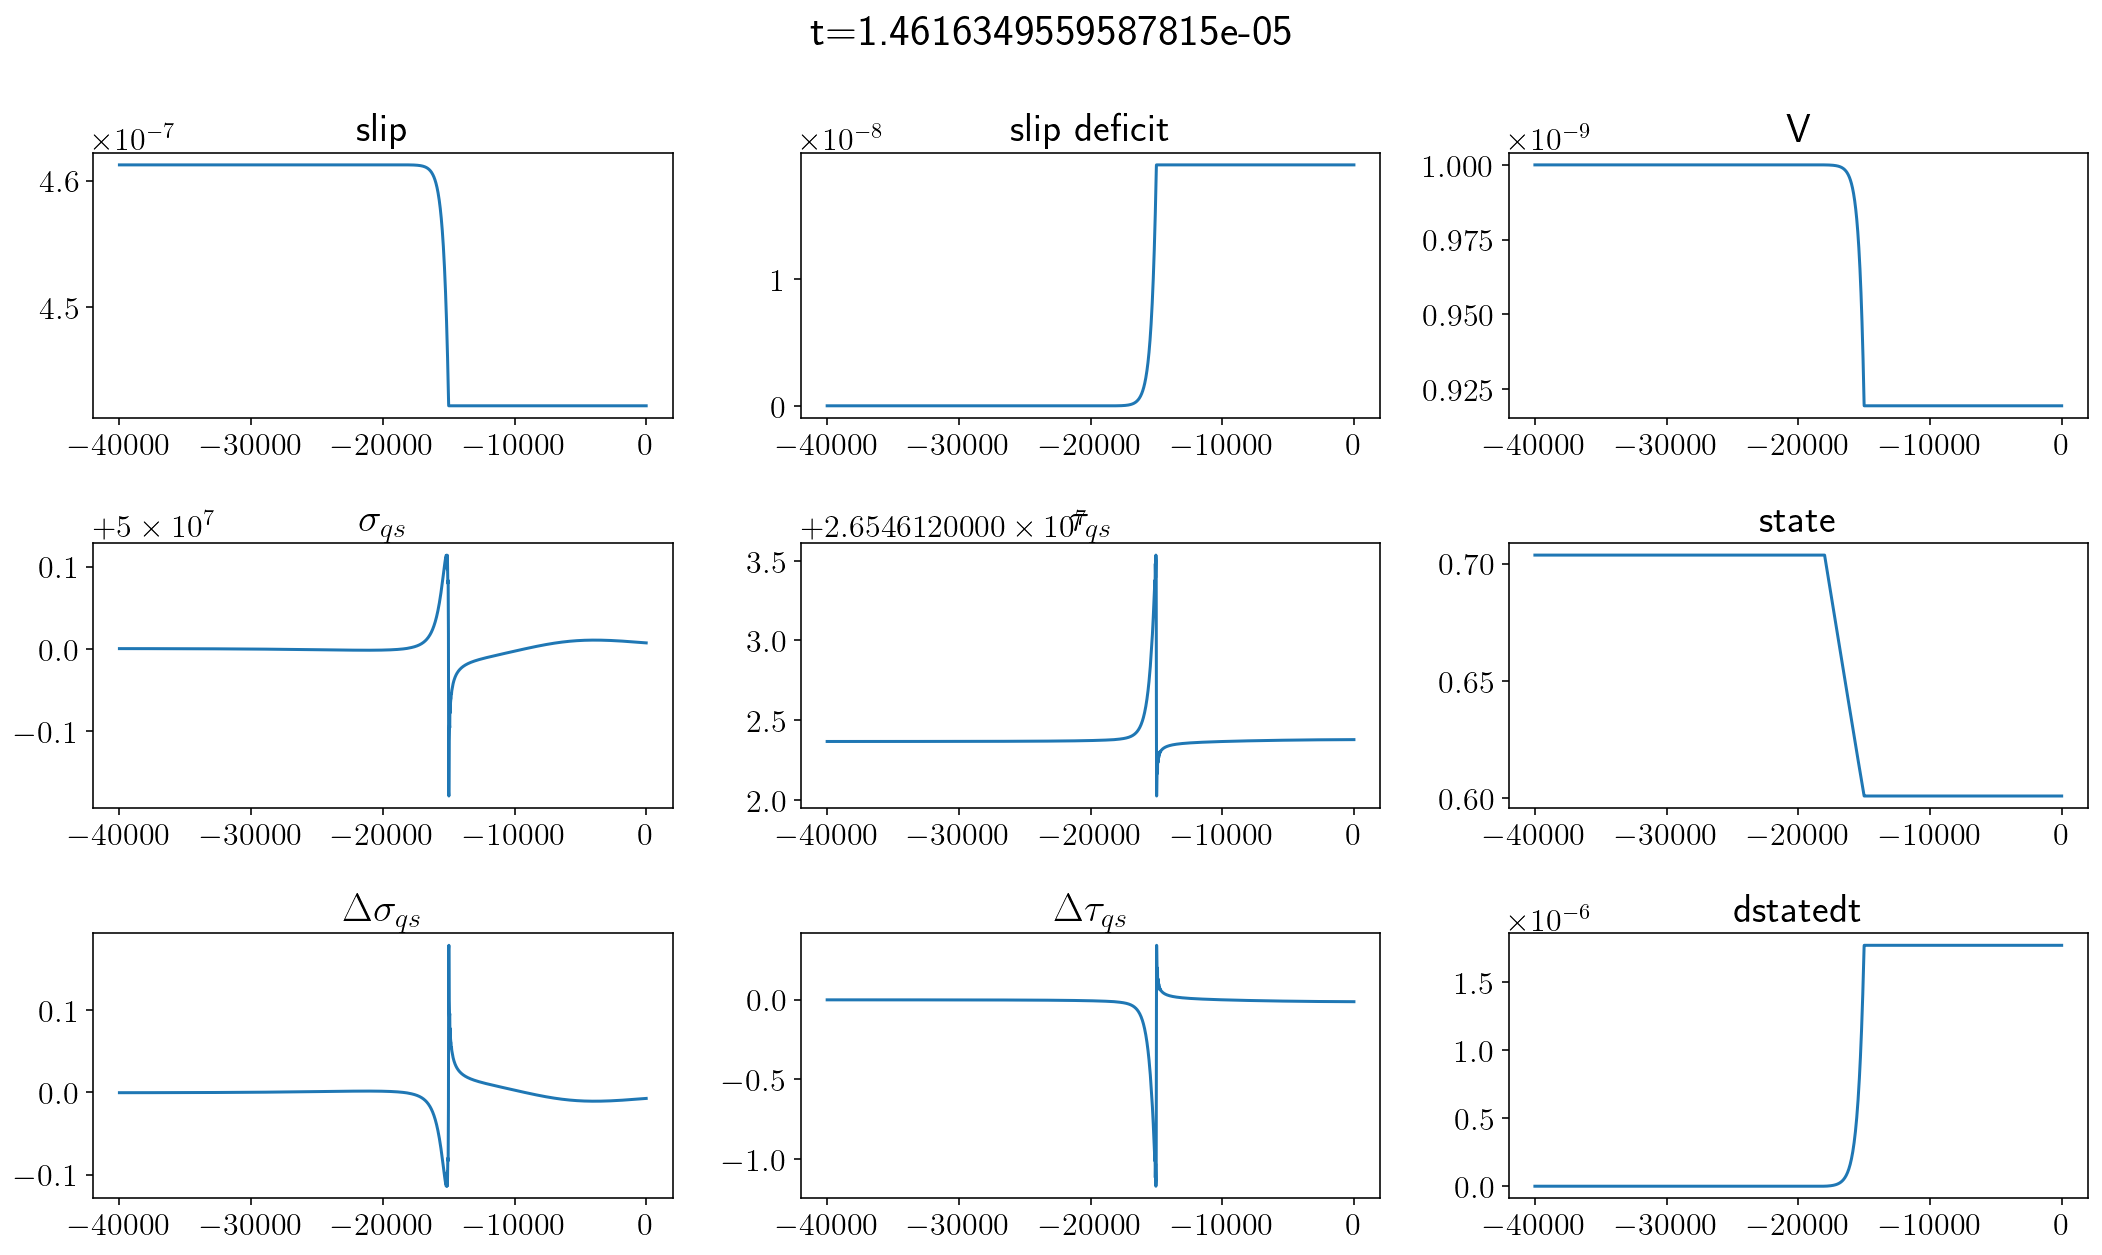

step=100, time=0.0767721219166074 yrs, step=0.0025573724266454555


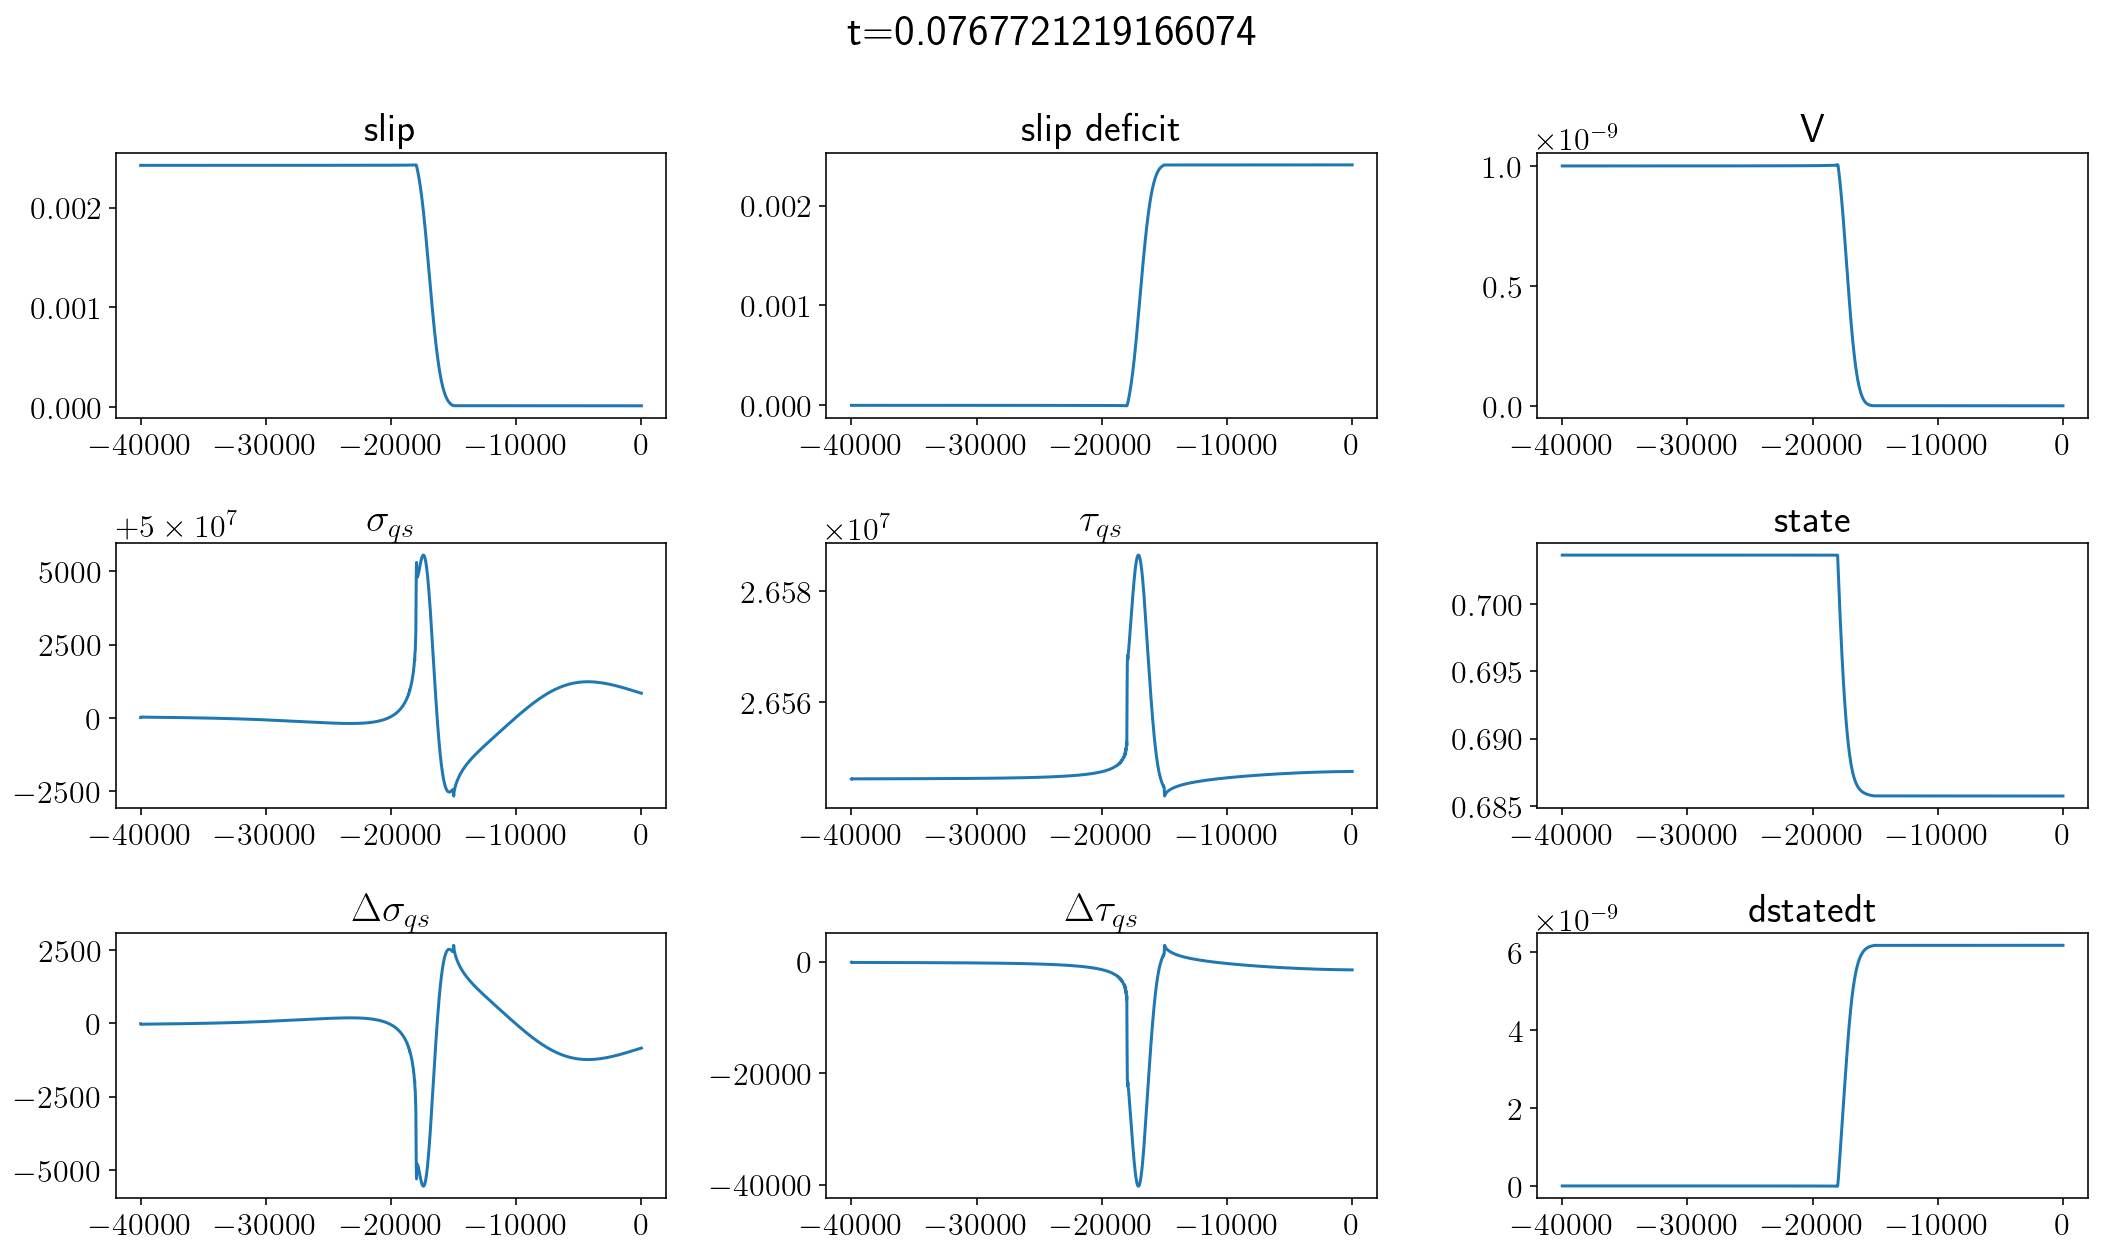

step=200, time=0.27359141819806637 yrs, step=0.0015236051587706224


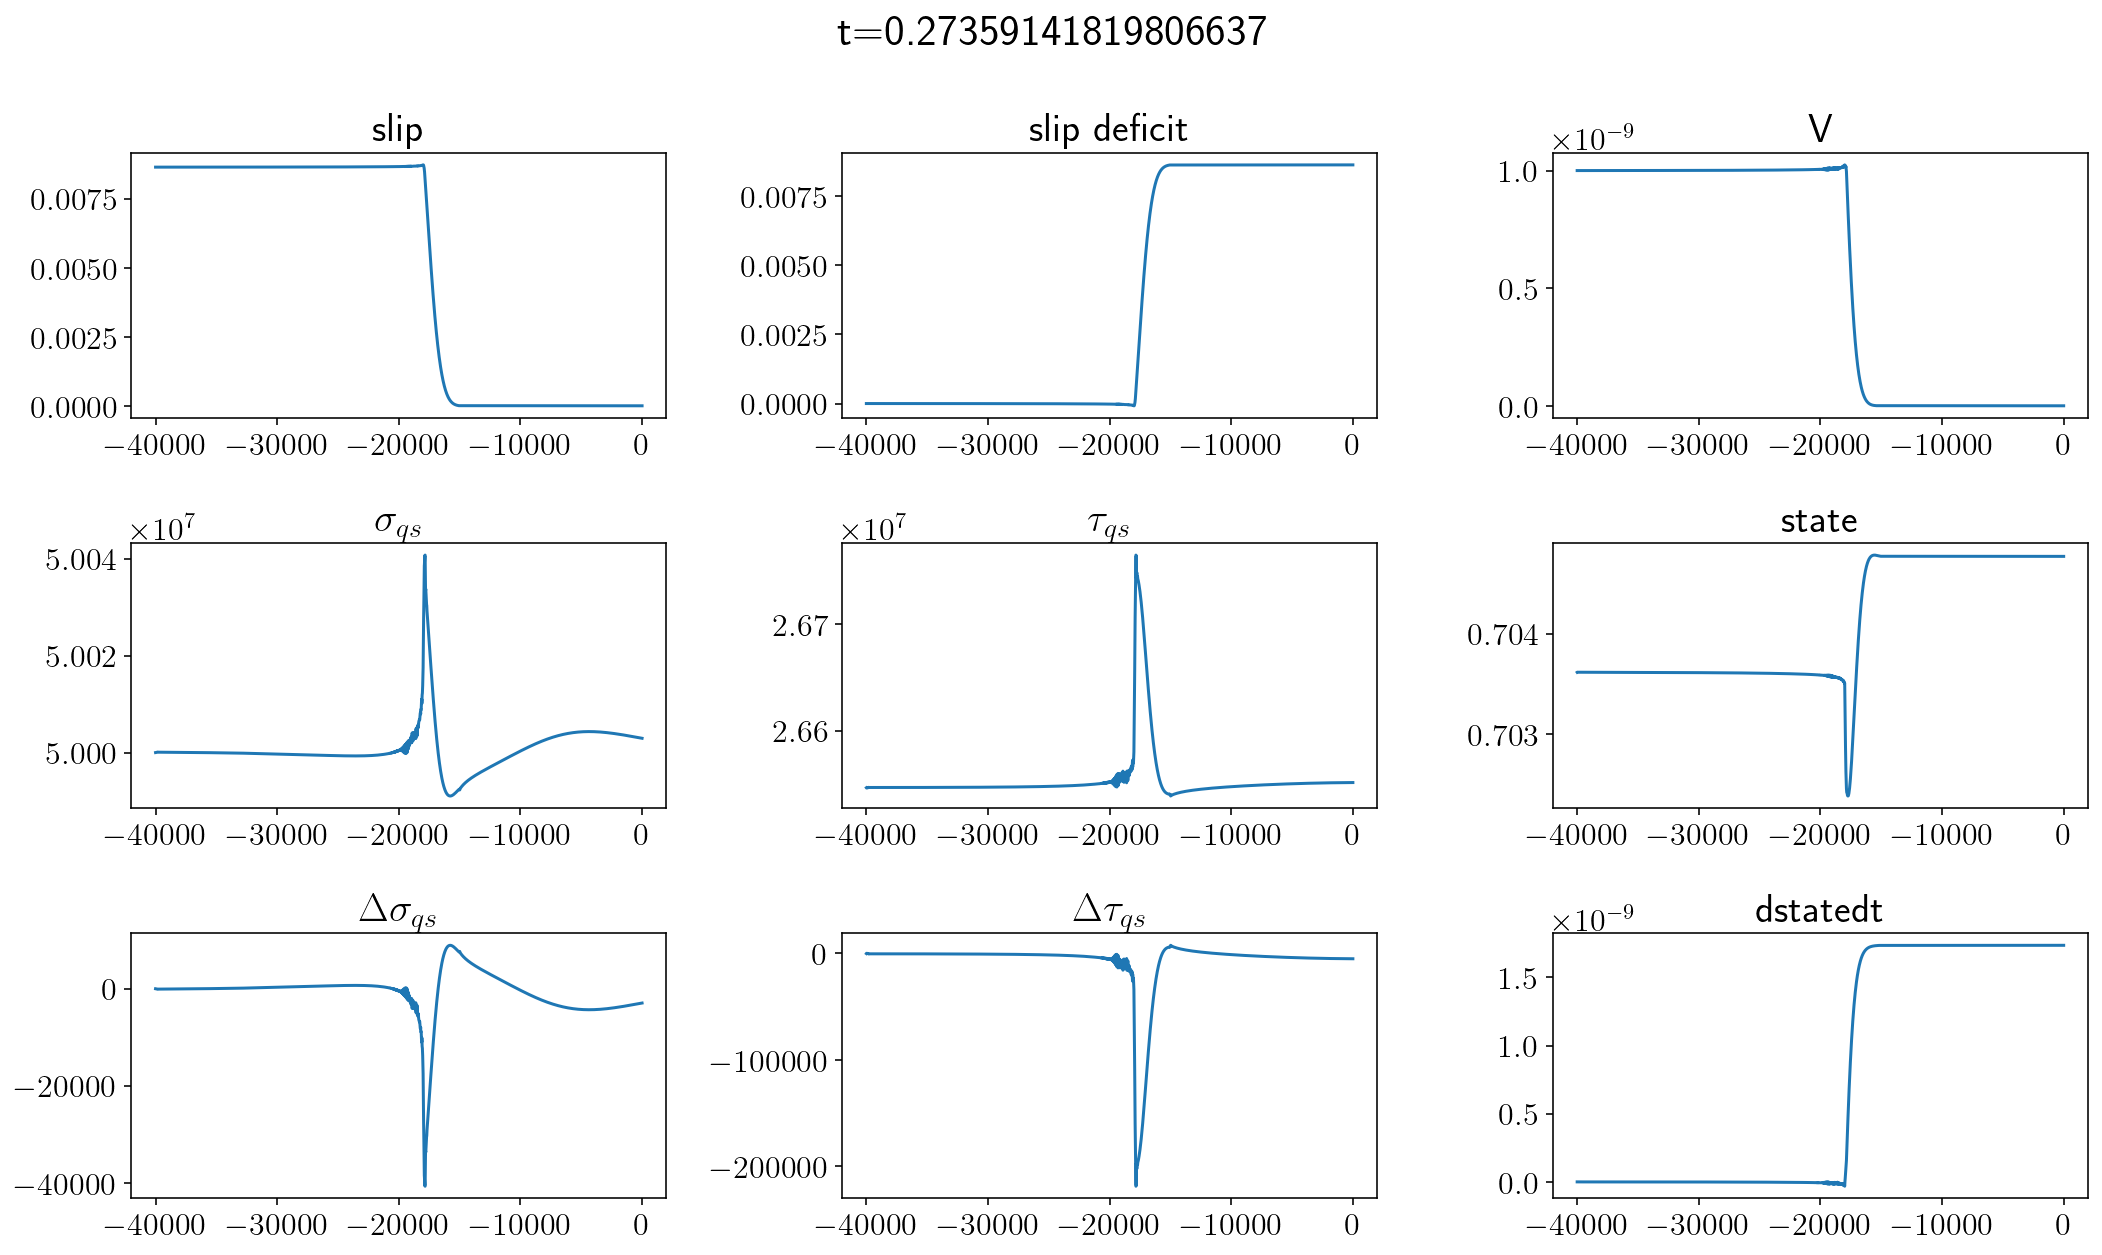

step=300, time=0.3988112522714105 yrs, step=0.0010238260514379286


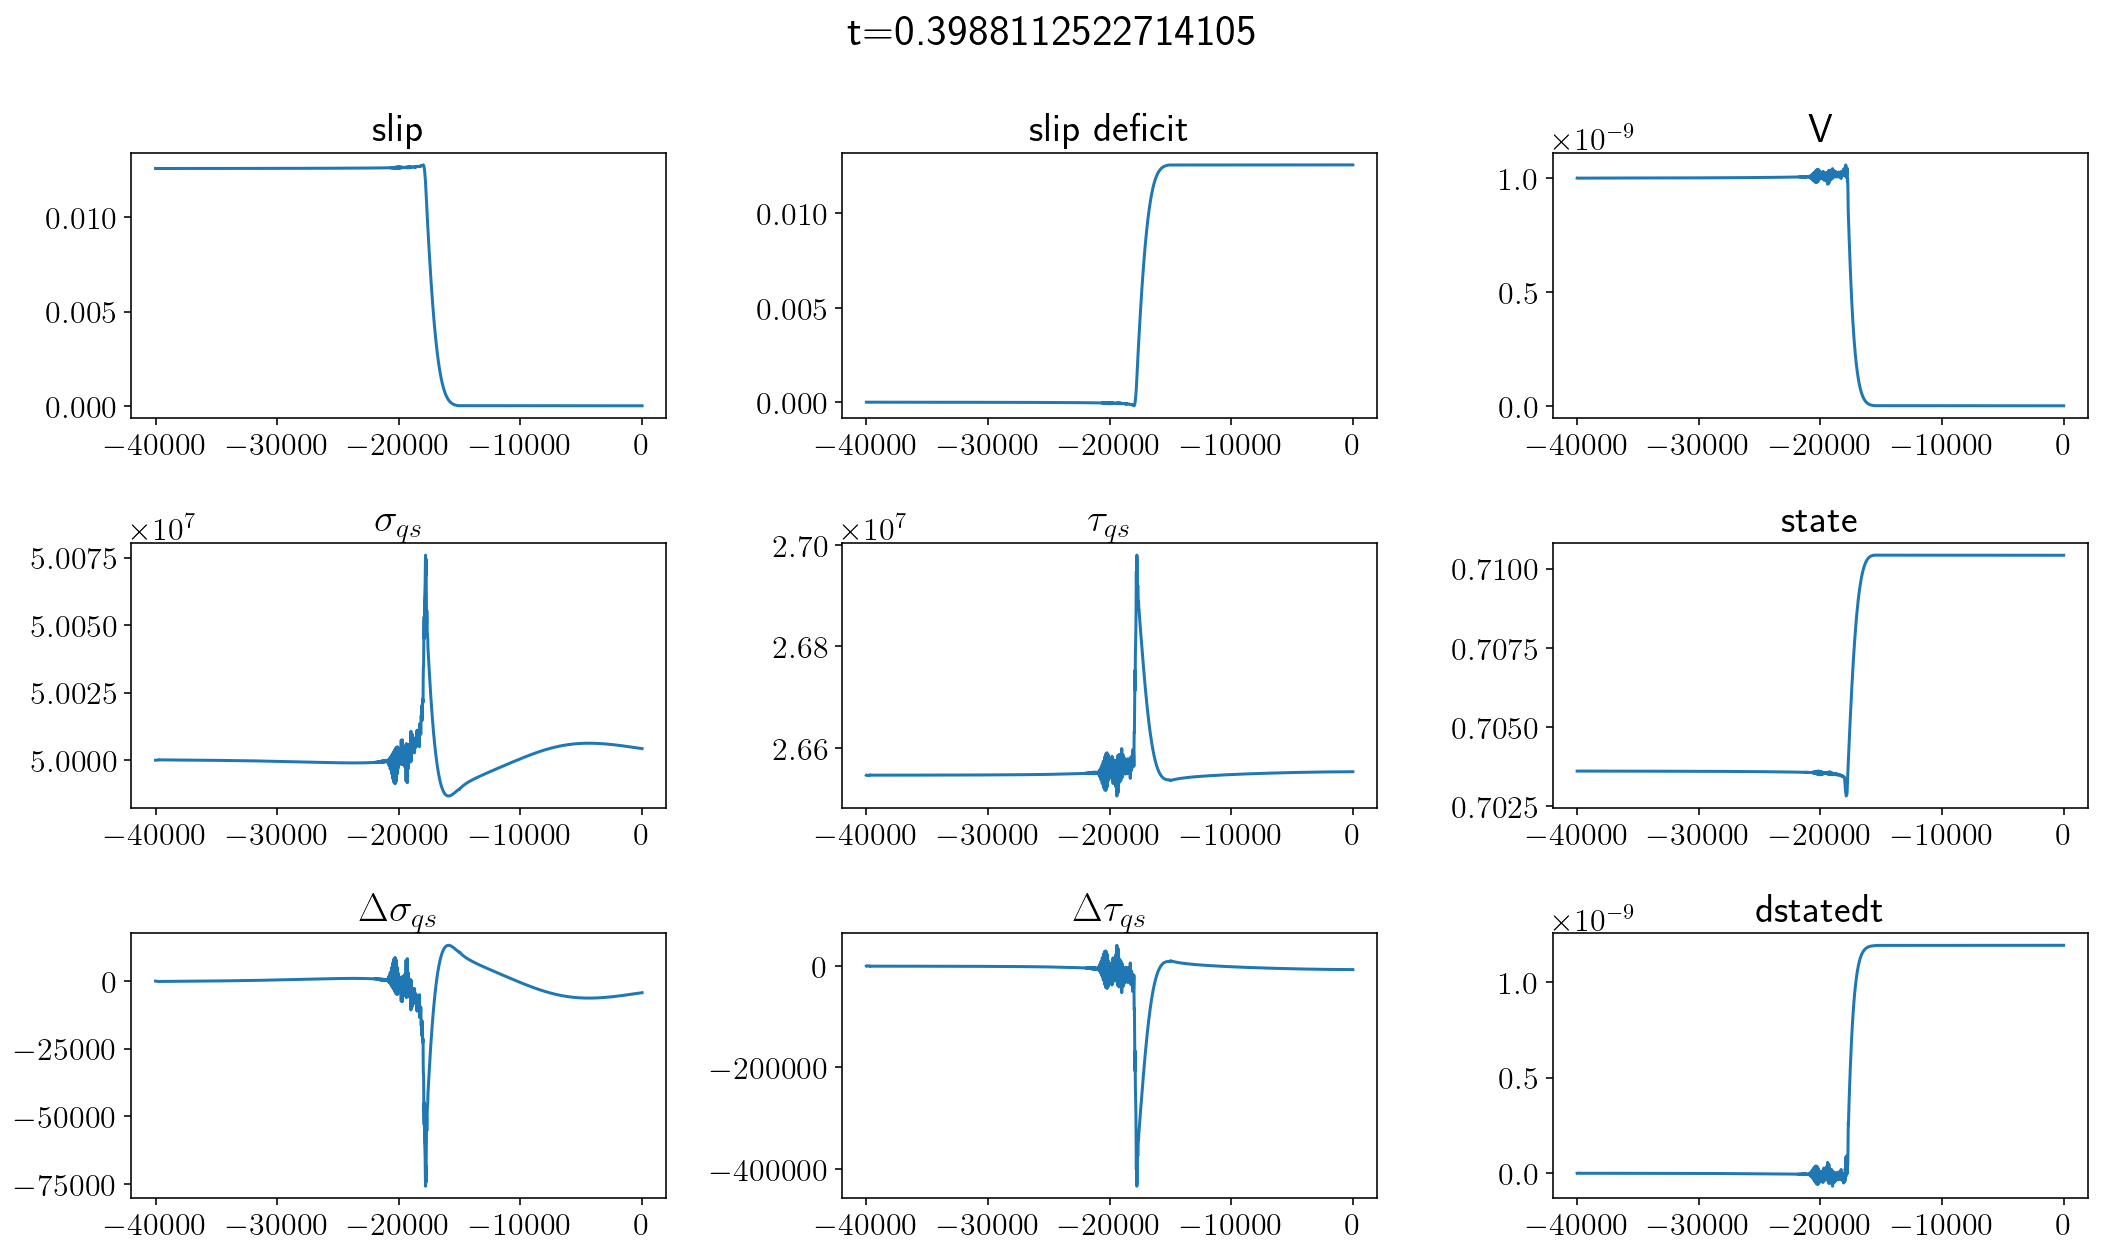

step=400, time=0.4888997454665483 yrs, step=0.0007855438398967987


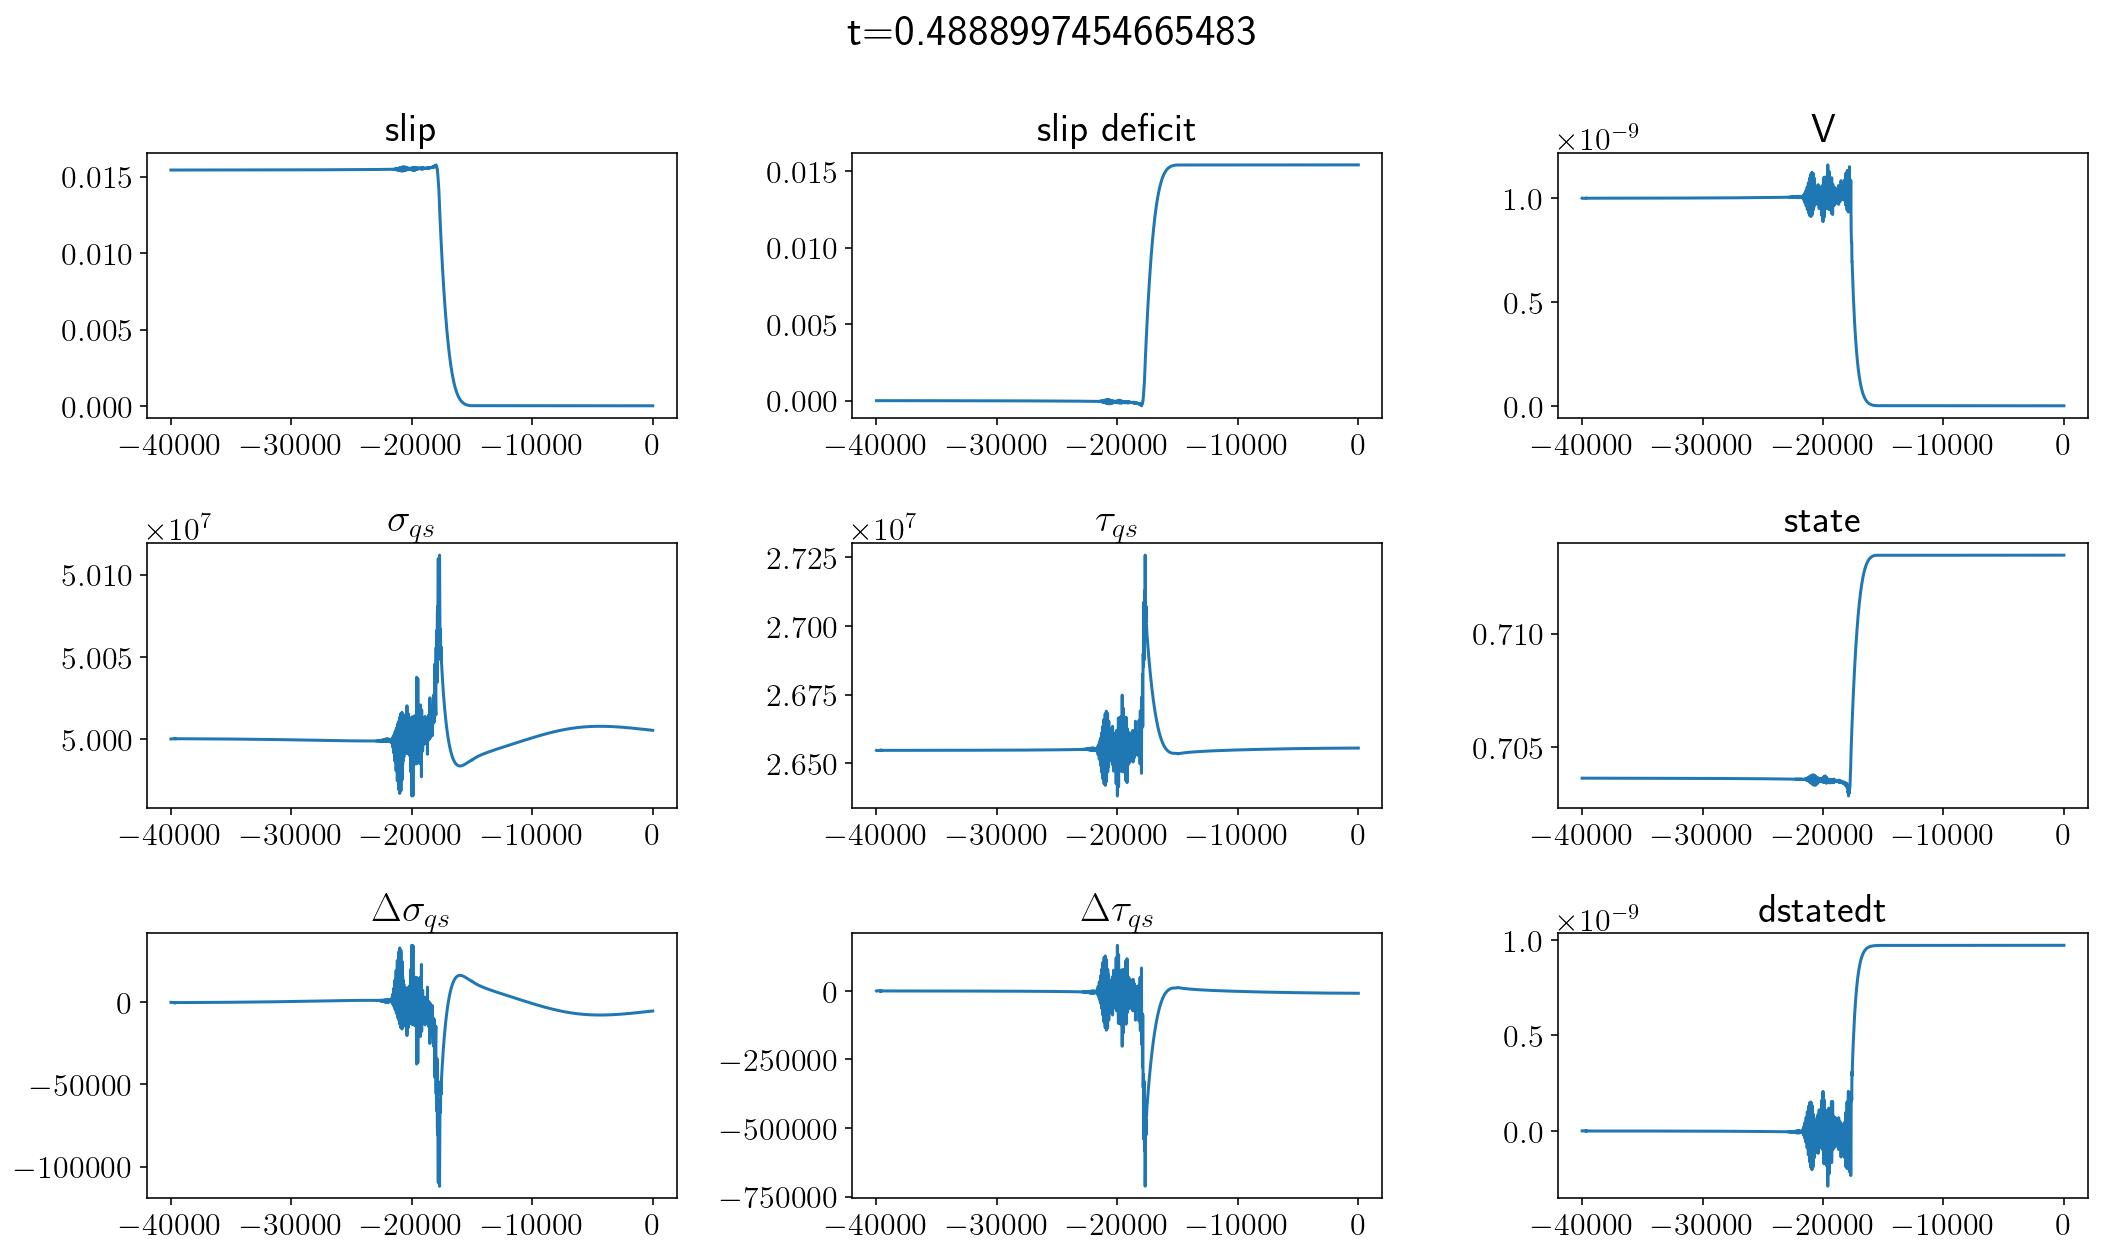

step=500, time=0.5606194961775048 yrs, step=0.0006532494822028827


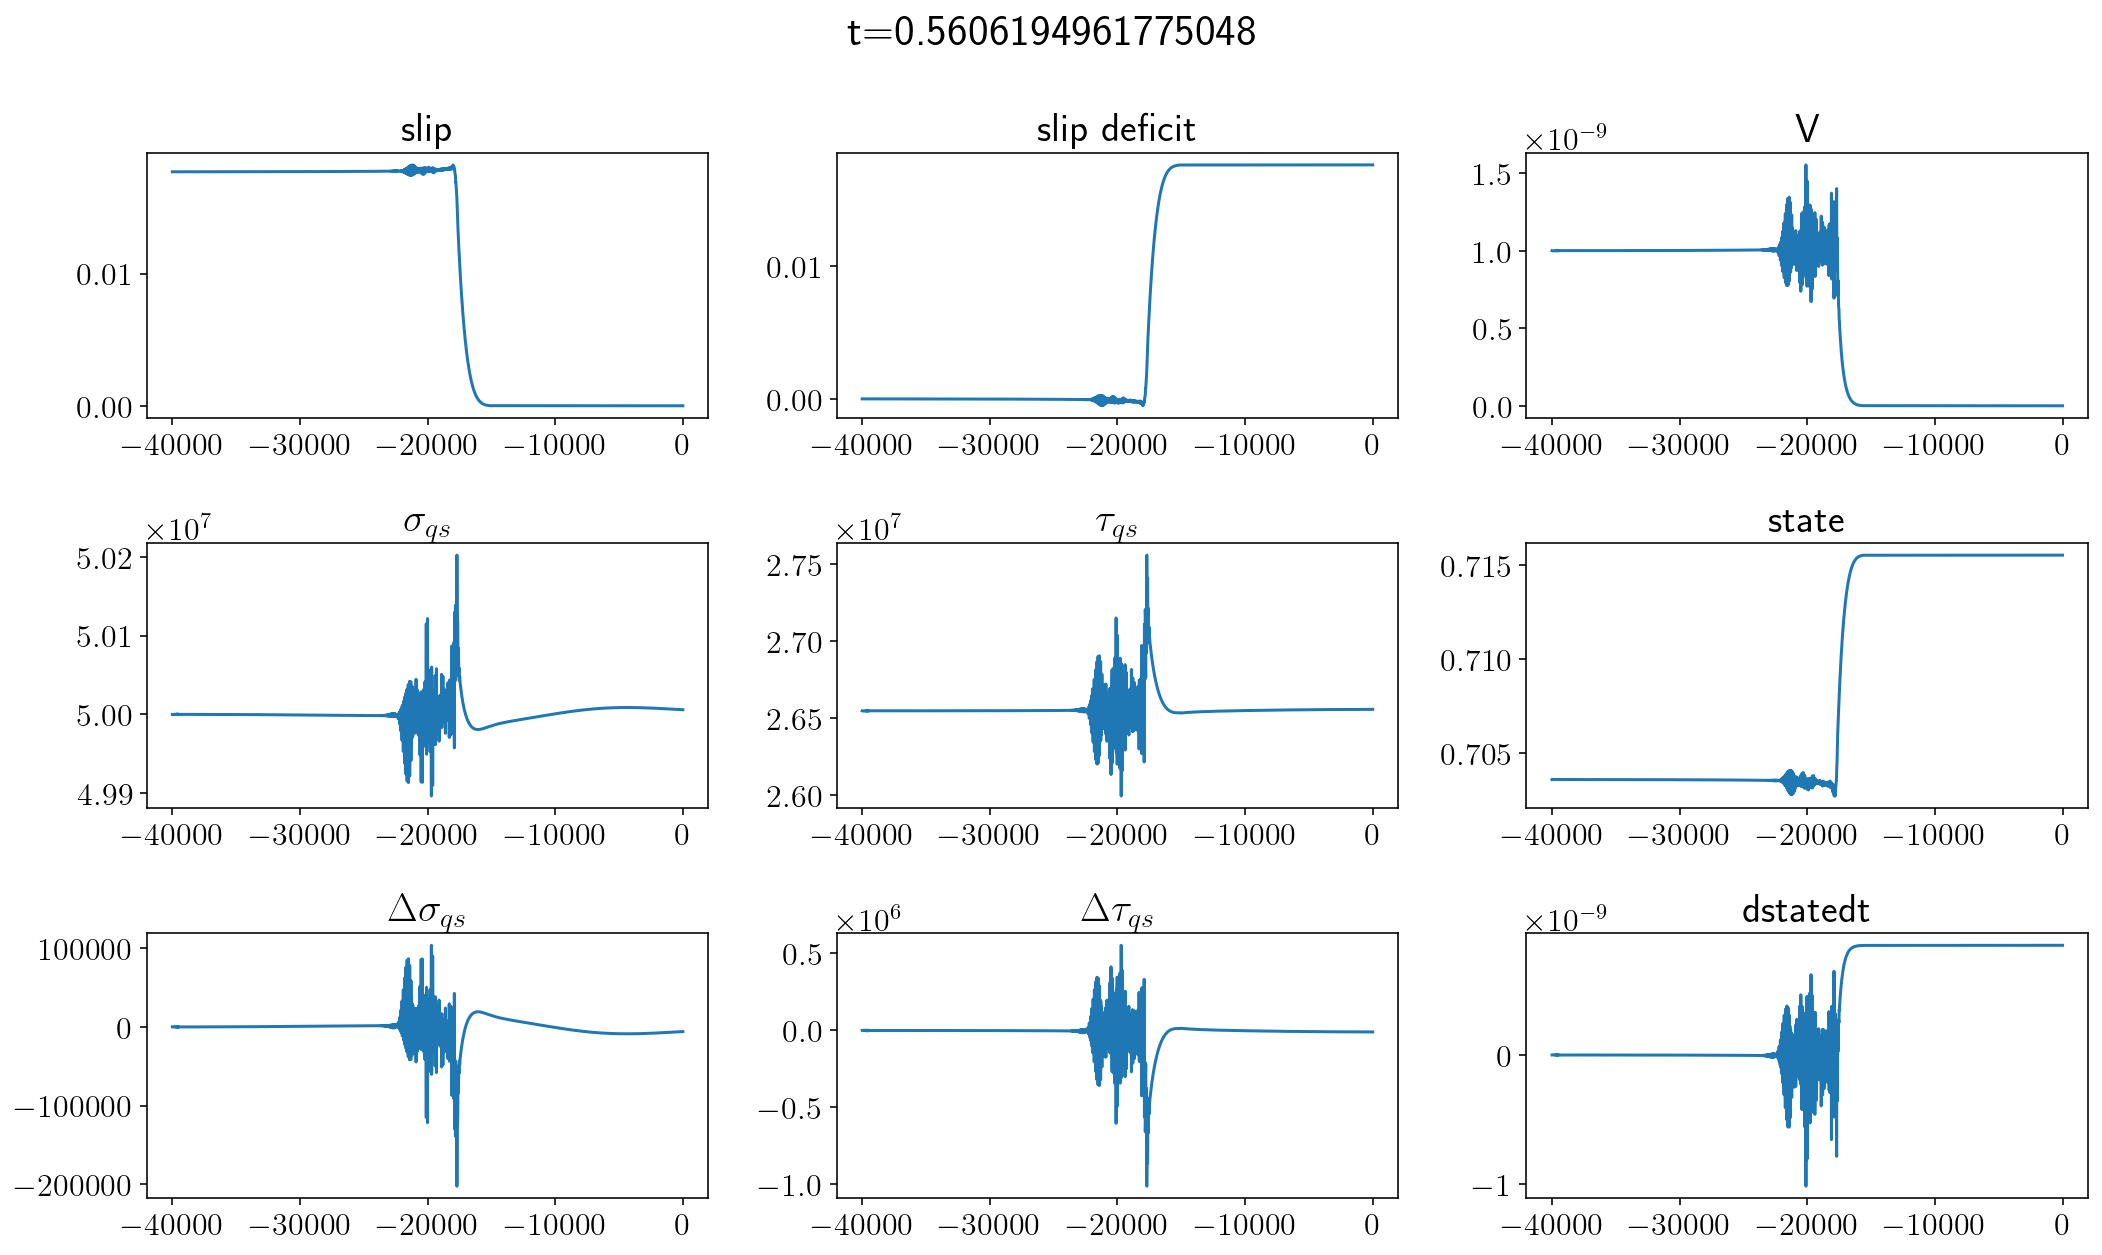

KeyboardInterrupt: 

In [86]:
%%time
from scipy.integrate import RK23, RK45

# We use a 5th order adaptive Runge Kutta method and pass the derivative function to it
# the relative tolerance will be 1e-11 to make sure that even 
state = SystemState()
derivs = lambda t, y: calc_derivatives(state, t, y)
integrator = RK45
atol = Vp * 1e-6
rtol = 1e-11
rk = integrator(derivs, 0, init_conditions, 1e50, atol=atol, rtol=rtol)

# Set the initial time step to one day.
rk.h_abs = 60 * 60 * 24

# Integrate for 1000 years.
max_T = 1000 * siay

n_steps = 2000
t_history = [0]
y_history = [init_conditions.copy()]
for i in range(n_steps):
    # Take a time step and store the result
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    # Print the time every 5000 steps
    if i % 1000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
    if i % 100 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
        plot_system_state(rk.t, state.data)

    if rk.t > max_T:
        break

y_history = np.array(y_history)
t_history = np.array(t_history)

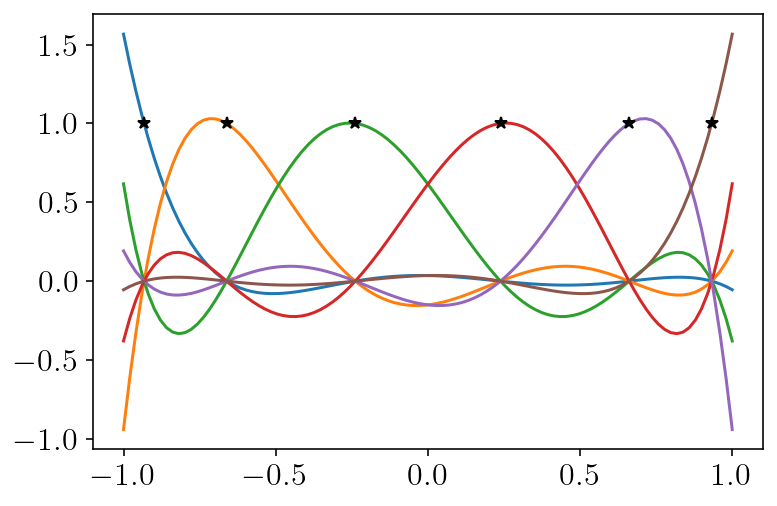

In [108]:
nq=6
V = data[-200, -nq:]
nodes = fault.qx
matrix = np.zeros((nq, nq))
for i in range(nq):
    matrix[:, i] = nodes ** i
coeffs = np.empty((nq, nq))
xs = np.linspace(-1, 1, 100)
for i in range(nq):
    rhs = np.zeros(nq)
    rhs[i] = 1
    coeffs[i,:] = np.linalg.solve(matrix, rhs)
    vs = np.sum(coeffs[None,i, :] * (xs[:, None] ** np.arange(nq)[None, :]), axis=1)
    plt.plot(xs, vs, '-')
    plt.plot([nodes[i]], [1], 'k*')
plt.show()

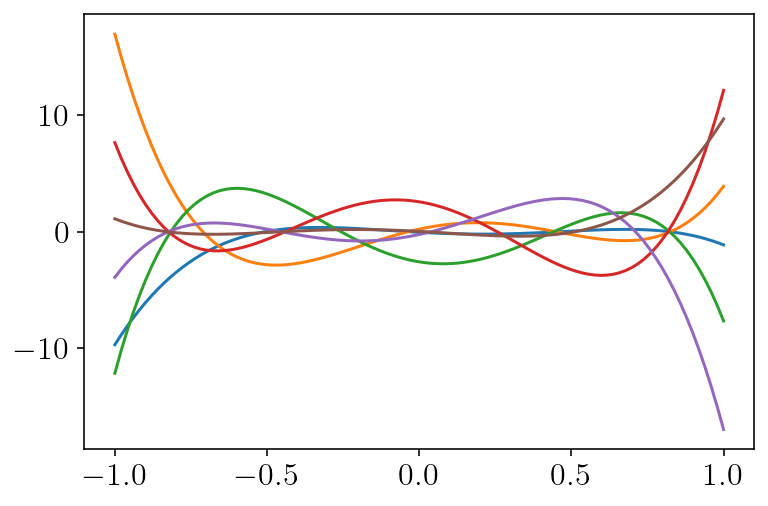

In [114]:
deriv_coeffs=coeffs[:,1:]*np.arange(1,nq)
for i in range(nq):
    vs = np.sum(deriv_coeffs[None, i, :] * (xs[:, None] ** np.arange(nq-1)[None, :]), axis=1)
    plt.plot(xs, vs, '-')
plt.show()

In [140]:
vs = np.sum(coeffs[None, 0, :] * (xs[:, None] ** np.arange(nq)[None, :]), axis=1)
deriv_vs = np.sum(deriv_coeffs[None, 0, :] * (xs[:, None] ** np.arange(nq-1)[None, :]), axis=1)
dist = xs[0] - nodes
kernel = fault.interp_wts / dist
kernel[0] / np.sum(kernel)- vs[0]
#vs[0]

-2.220446049250313e-16

In [135]:
dkernel 

array([334.72892369, -40.07765197,  11.69838734,  -4.42032548,
         1.66692575,  -0.40875934])

In [149]:
xs[0]

-1.0

In [148]:
dkernel = -fault.interp_wts / (dist**2)
from tectosaur2.mesh import barycentric_deriv
dv = barycentric_deriv(np.array([-1]), fault.qx, fault.interp_wts, [1,0,0,0,0,0])
dv- deriv_vs[0], dIm.dot([1,0,0,0,0,0])

(array([8.8817842e-15]), array([11.59234368,  0.01415617]))

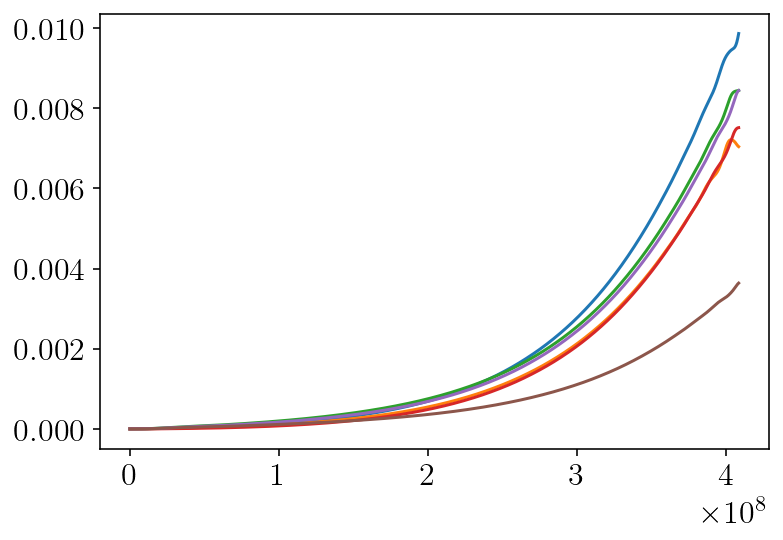

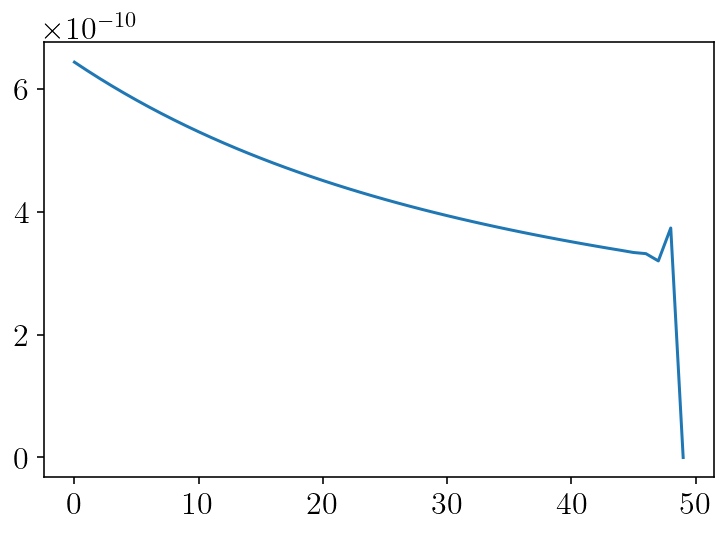

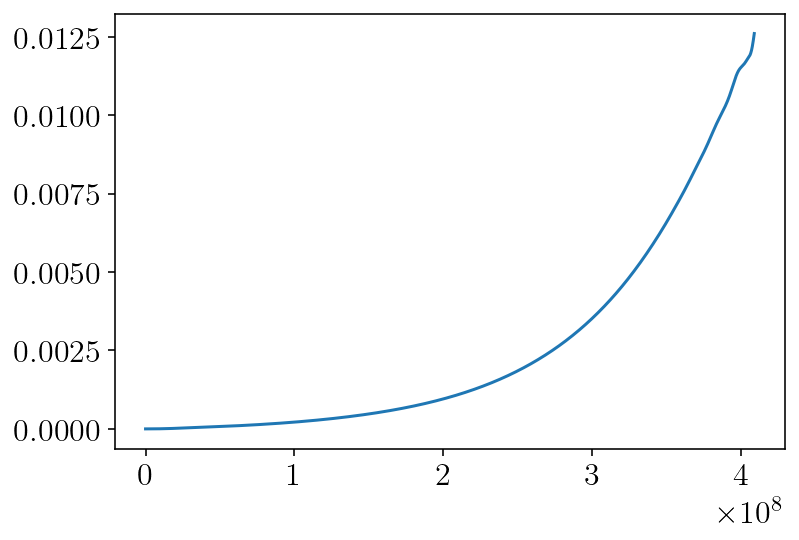

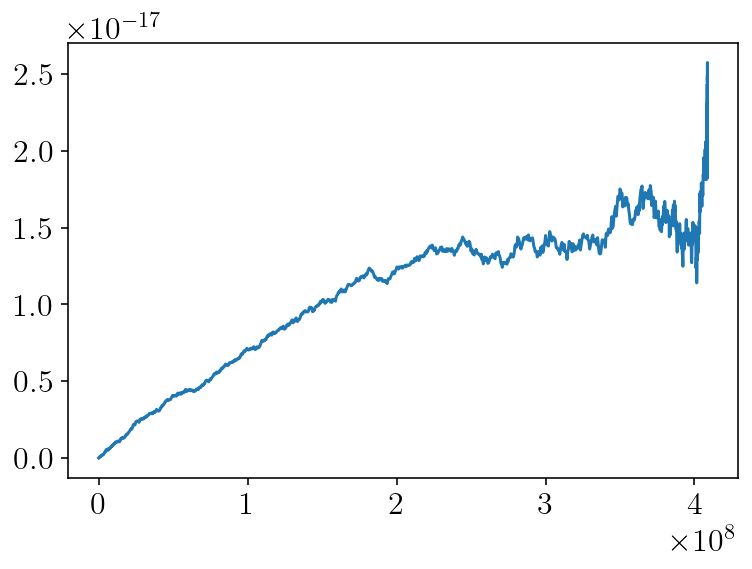

In [82]:
y_history = np.array(y_history)
t_history = np.array(t_history)
data = y_history[:, :init_slip_deficit.shape[0]]
tips = data.reshape((-1, 6)).dot(Im.T).reshape((t_history.shape[0], -1, 2))
np.testing.assert_allclose(tips[:,:-1, 1], tips[:,1:,0], atol=1e-10)

plt.plot(t_history, data[:, -6:])
plt.show()

plt.plot(tips[50, -50:, 1])
plt.show()

plt.plot(t_history, tips[:, -1, 0])
plt.show()
plt.plot(t_history, tips[:, -1, 1])
plt.show()

## Plotting the results

Now that we've solved for 1000 years of fault slip evolution, let's plot some of the results. I'll start with a super simple plot of the maximum log slip rate over time.

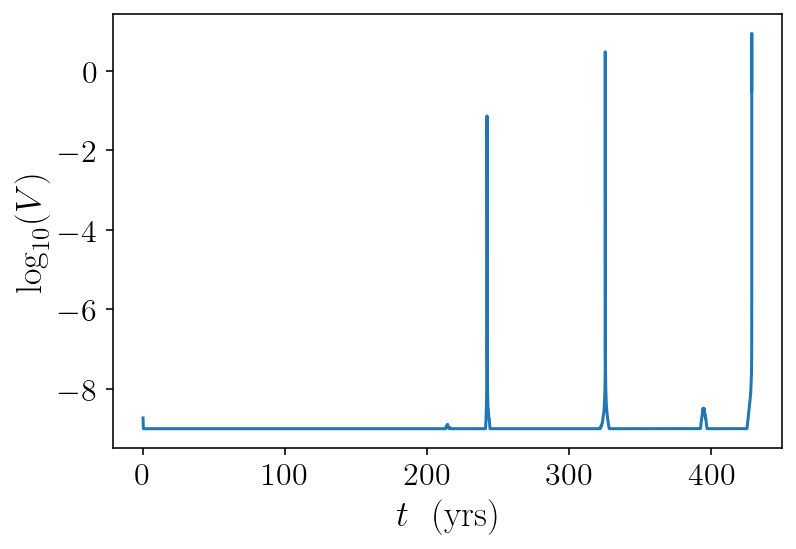

In [ ]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.xlabel('$t ~~ \mathrm{(yrs)}$')
plt.ylabel('$\log_{10}(V)$')
plt.show()

And next, we'll make the classic plot showing the spatial distribution of slip over time:
- the blue lines show interseismic slip evolution and are plotted every fifteen years
- the red lines show evolution during rupture every three seconds.

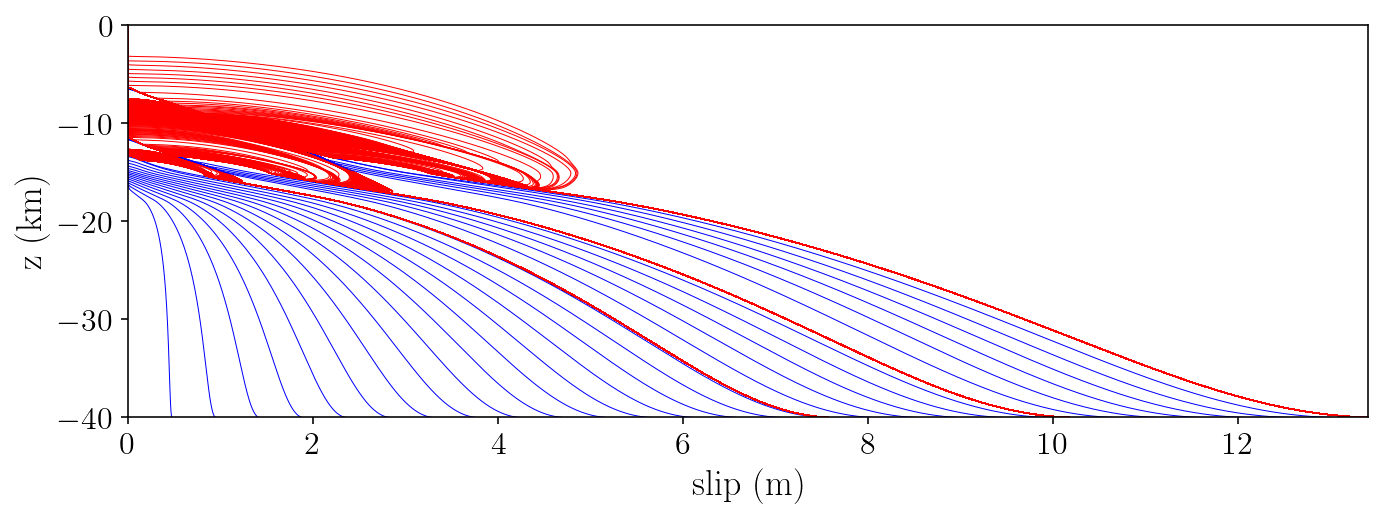

In [ ]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip_deficit
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip_deficit.shape[0]]
    should_plot = False

    # Plot a red line every three second if the slip rate is over 0.1 mm/s.
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"
    
    # Plot a blue line every fifteen years during the interseismic period
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"

    if should_plot:
        # Convert from slip deficit to slip:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fd / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

And a plot of recurrence interval:

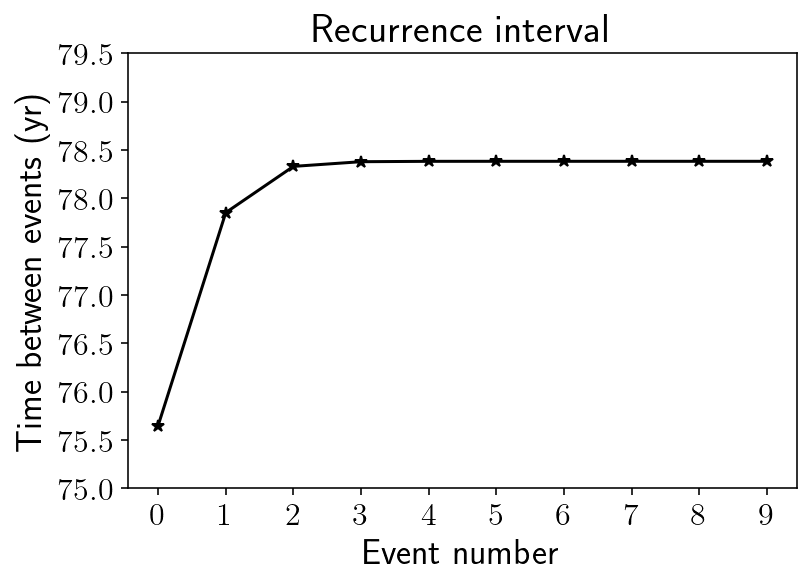

In [ ]:
plt.title("Recurrence interval")
plt.plot(np.diff(event_times) / siay, "k-*")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel("Event number")
plt.ylabel("Time between events (yr)")
plt.show()

## Comparison against SCEC SEAS results

In [3]:
import numpy as np
ozawa_data = np.loadtxt('bp3-qd-ozawa.3.txt')

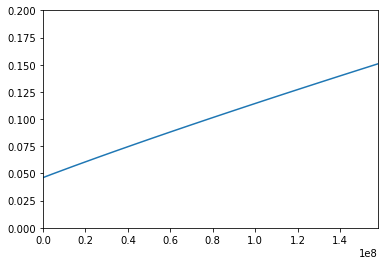

In [13]:
ozawa_t = ozawa_data[:,0]
ozawa_shear_stress = ozawa_data[:, 3]
siay = 365 * 24 * 3600
import matplotlib.pyplot as plt
plt.plot(ozawa_t, ozawa_shear_stress-26.5)
plt.xlim([0, 5*siay])
plt.ylim([0, 0.2])
plt.show()

In [ ]:
k